# Analysis of football match statistics and outcomes

## Initial Aims for exploration:
- Import all matches from 2008 - 2016 including data on:
    - Teams involved
    - Match Outcome
    - Match Stats e.g. shots, possession, bookings etc
    - ID of the players in the match day starting 11 plus their ability ratings
    - Other info that can be engineered that I feel is relevant to match outcome

- MVP: Build a model for match prediction for English Premier League games - based on 
    - the team stats e.g. avg goals per game, 
    - ratings of players in the starting 11
    - last 5 results
    - home team's form

- Stretch 1 - is the style of win changing (2008 - 2011 Tiki Taka in the ascendancy on the continent; 2013- gegenpressing in Germany). Do the match stats show a difference in manner of victory?

The database is in SQL so we'll use SQLite to bring it in and do some initial analysis on a few tables

In [813]:
# imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import warnings

warnings.simplefilter('ignore') # this is to ignore warnings that are not useful

## What is in this database?

There are seven SQL tables available. Reading from the Kaggle Data Card:

- **Country**: We will take England only for the MVP (country id 1729) and we'll use this to join up the English Premier League Matches in the Match table

- **League**: The top tier league in all of the countries in Country are here. 
    - Includes Spain, France, Italy and Germany (with England they make up the top 5 European Leagues) and Scotland among others. We are beginning with just England (league id 1729 like the country id)

- **Match**: 26,000 rows with country id and league id. Other columns include:
    - stage, which presumably is the round in the season e.g. in a 20-team home-and-away season of 38 games, stage 1 is the opening round and 38 is the final game day. Easy to audit this - England is 20 teams and there should be exactly 38 stages in every season

    - Home team and away team identifiers; 

    - home goals & away goals
    
    - **home and away players X and Y coordinates.** I think this is their average position. From just eyeballing this, 1 is the goalkeeper and this is very narrowly defined (because goalkeepers don't move much compared to other positions). It's missing for about 7% of records, probably the earlier seasons in some leagues before it was recorded

    - Key match stats, but data appears to be missing for 45% of records (according to the Kaggle data card):
        - Goals
        - Shot on target
        - shot off target
        - foul committed
        - cards
        - crosses
        - corner
        - possession
    
     
    - Bet 365 odds (B365H / B365D / B365A) - ignore for now, we are trying to do our own and could compare to these *later*
        - Lots of other columns which are for betting providers too. We can ignore for now 
            - BWH, BWD, BWA, 
            - IWH, IWD, IWA, 
            - LBH, LBD, LBA... These all have Home, Draw, Away and I think they are all bookmaker stats

- **Player** - Basic info like DOB, Height, Weight

- **Player_Attributes** - more detailed stats like overall_rating, potential, pref. foot, work rates, crossing, finishing etc. This information is provided from the FIFA video games which gives every player a measure of ability

- **Team** - Very basic identifying info like Name & id for link to other tables

- **Team_Attributes** - more detail around build up play statistics and it is recorded once per year. Also comes from FIFA data
    - is it changing over time?

## What Questions can we answer with a predictive model?

### 1. MVP: Can we predict match outcome? Data columns could include
- **Home & away team,** result which we engineer from home goals & away goals, with winning team id
- **OVR Rating of the starting 11**, coming from Player_attributes via player_api_id.
    - Start with avg OVR rating. Then maybe add OVR rating for Strikers, Goalkeeepers
    
- V2 of the model explored:
    - More fluid features such as recent form of the team (points gained from last 5 games), points per game averaged this season.
    - 'Sharper' indicators of team quality e.g. OVR rating of the best player on the team.

- **For more granular data**, bring in players' work rates, GK overall, overall finishing stats.
    - NOTE: there is no data column for player position. There are too many to label manually, so we could implement a rule based on some of the key player stats to identify this. BY far the easiest will be goalkeeper, and we add OVR rating for that.
    - Any other granular data for the most likely stats to impact goals scored/conceded, because that's the direct influence on the results


### 2. Stretches  - once we have done the MVP

- How does Height/Weight affect style of play? Taller, bulkier players mean a faster long-ball style of play?

-  Physical vs Technical - which ability set is more important in the winning teams?
    - Physical: Acceleration, Sprint Speed, Agility, Reactions, Balance, Jumping, Stamina, Strength
    - Technical: Crossing, Finishing, Heading Acc., Short Passing, Volleys, Dribbling, Curve, FK Acc., Long Passing, Ball Control
    - Mental: Aggression, Interceptions, Positioning, Vision, Penalties (it's psychological)



## Learnings from V1 and V2 of the model

- Performance beyond 50-52% has been a maximum when focusing on team-wide features like the team's (starting 11) overall average rating, their net goals scored/conceded, their form in the last 5 games, particularly the difference between the home team and the other. 
- PCA had revealed the most variation between some of these features and the difference between home and away teams for it, but after two runs where the second added more features and saw slightly decreased performance, I will try and pivot to the perspective being on one team
- The upper limit of performance with Win, Draw or Loss was around 50-52% and the performance beyond chance (33%) was mostly driven by a big bias towards home victories, given the prior probabilities calculated below. So we will try and simplify by going to predict just the home team winning or not for V3

## Open the database (pandas)

In [828]:
# import the database file
with sqlite3.connect('/Users/thomasdoherty/Desktop/football-project/football-data/database.sqlite') as conn:
    all_countries = pd.read_sql_query("SELECT * from Country", conn)
    all_matches = pd.read_sql_query("SELECT * from Match", conn)
    all_leagues = pd.read_sql_query("SELECT * from League", conn)
    all_teams = pd.read_sql_query("SELECT * from Team", conn)

    # get matches from outside England (league id 1729) for a base rate W/D/L comparison
    european_matches = pd.read_sql_query("SELECT * FROM Match WHERE league_id != 1729", conn)

In [829]:
all_teams.sample(5) # we want to use team_long_name and bring that into the matches dataframe

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
265,43049,8558,452.0,RCD Espanyol,ESP
106,15629,8398,162.0,FC Energie Cottbus,COT
273,43804,9867,260.0,CD Tenerife,TEN
165,26556,8640,247.0,PSV,PSV
255,43039,9783,242.0,RC Deportivo de La Coruña,COR


In [830]:
selected_countries = ['England'] # leave this format in case we want to add more countries later
countries = all_countries[all_countries.name.isin(selected_countries)] # England id is 1729

# merge leagues - it is only going to be premier league, but incase other leagues are added in the future
leagues = countries.merge(all_leagues, on='id', suffixes=('', '_y')) # suffixes = ('', '_y') is to avoid duplicate columns


In [831]:
# checking that English matches have been removed properly
print(european_matches.shape)
print(all_matches.shape)

(22939, 115)
(25979, 115)


In [832]:
# check all columns - more exploration done above and we will remove all the bookies columns soon
all_matches.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=115)

In [833]:
matches_prem = all_matches[all_matches.league_id.isin(leagues.id)] 
# Above, we could do league_id == 1729, but this is more flexible when we decide to add more leagues,
# We just add the country name two code cells above and it will work

Below I will **remove the bookmakers odds columns** - they begin with Bet 365 (B365X, where X = H for a bet on the Home team winning; D for Draw, A for Away team, and have many outlets inc. Ladbrookes (LBX), Bet Victor (VCX), William Hill (WHX)) so I will cut off the matches df from the Bet 365 columns onwards.

In [834]:
# 86th column is B365H - remove everything from here onward
matches_prem = matches_prem.iloc[:, :85]

## Initial Data Cleaning & Exploratory Data Analysis (EDA) in Pandas

Initial Look after betting odds columns have been removed:

In [835]:
matches_prem.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,34574.0,37799.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,25922.0,27267.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,24635.0,30853.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,127857.0,34466.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,33633.0,107216.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...


Add team names

In [836]:
# Merge the home team name
matches_prem = matches_prem.merge(
    all_teams[['team_api_id', 'team_long_name']],
    how='left',
    left_on='home_team_api_id',
    right_on='team_api_id'
).rename(columns={'team_long_name': 'home_team'})

# Drop the redundant team_api_id column (if necessary)
matches_prem = matches_prem.drop(columns=['team_api_id'])

# Merge the away team name
matches_prem = matches_prem.merge(
    all_teams[['team_api_id', 'team_long_name']],
    how='left',
    left_on='away_team_api_id',
    right_on='team_api_id'
).rename(columns={'team_long_name': 'away_team'})

# Drop the redundant team_api_id column (if necessary)
matches_prem = matches_prem.drop(columns=['team_api_id'])

# Preview the result
print(matches_prem[['home_team_api_id', 'home_team', 'away_team_api_id', 'away_team']].head())


   home_team_api_id          home_team  away_team_api_id             away_team
0             10260  Manchester United             10261      Newcastle United
1              9825            Arsenal              8659  West Bromwich Albion
2              8472         Sunderland              8650             Liverpool
3              8654    West Ham United              8528        Wigan Athletic
4             10252        Aston Villa              8456       Manchester City


### Comments for initial cleaning & EDA
- Stripping out unnecessary ID columns
- Renaming and reordering columns for clarity and ease of reading
- casting to appropriate data type

Notes for cleaning

- We don't need the country_id and league_id when we know all of these are Premier League games for the MVP. We can remove these columns, keep the id as the index column.

- We can clean the other columns so it is readable e.g. the match stats look like they've been scraped from HTML. We can parse and extract the important stuff like goals.

- Maybe later, we will feature engineer for last five results to show recent form going into this game (date will be important)

- For prediction, the **base rate** is important. Before we introduce any specific team information at all, how often do Home wins, draws or away wins occur? we should look at all leagues for a solid base rate not just England

In [837]:
# make a prem df where we drop the country_id and league_id columns
prem = matches_prem.drop(['country_id', 'league_id'], axis=1)

In [838]:
# check obvious data types we can change right now
prem.dtypes

id               int64
season          object
stage            int64
date            object
match_api_id     int64
                 ...  
cross           object
corner          object
possession      object
home_team       object
away_team       object
Length: 85, dtype: object

Date can become a datetime

In [839]:
# cast the date column to datetime
prem['date'] = pd.to_datetime(prem['date'])

In [840]:
# rename columns to make them more understandable

# rename stage to round / 38 rounds in a premier league season
prem = prem.rename(columns={'stage': 'Gameweek / 38'})

# rename values in season - split the season before and after the / and take the last two characters of both
prem['season'] = prem['season'].apply(lambda x: x.split('/')[0][2:] + '/' + x.split('/')[1][2:])

prem = prem.rename(columns={'home_team_goal': 'Home GS', 'away_team_goal': 'Away GS', 'home_team_api_id': 'Home ID', 'away_team_api_id': 'Away ID'})

# the same for all_matches
european_matches = european_matches.rename(columns={'home_team_goal': 'Home GS', 'away_team_goal': 'Away GS', 'home_team_api_id': 'Home ID', 'away_team_api_id': 'Away ID'})

For now we won't use the X and Y coordinates of the players so we will remove those columns

In [841]:
# remove player coordinates more concisely
prem = prem[prem.columns.drop(list(prem.filter(regex='(home|away)_player_(X|Y)[1-9]|(home|away)_player_(X|Y)10|(home|away)_player_(X|Y)11')))]

# cast home_player_1 to home_player_11 to int
# Use a combined regex to match and cast both 'home_player_1' to 'home_player_11' and 'away_player_1' to 'away_player_11' to Int64
prem[prem.filter(regex='(home|away)_player_[1-9]|(home|away)_player_10|11').columns] = \
    prem.filter(regex='(home|away)_player_[1-9]|(home|away)_player_10|11').astype('Int64')

In [842]:
# insert the home and away team names at the start of the df, after date and before the rest of the columns
prem = prem[['id', 'season', 'date', 'Gameweek / 38', 'home_team', 'Home GS', 'Away GS', 'away_team'] + [col for col in prem.columns if col not in ['id', 'season', 'date', 'Gameweek / 38', 'home_team', 'Home GS', 'Away GS', 'away_team']]]

In [843]:
prem.sample(5)

,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,match_api_id,Home ID,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
705,2434,09/10,2009-08-29,4,Blackburn Rovers,0,0,West Ham United,658608,8655,...,160496,34543,<goal />,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><event_incident_typefk>123</even...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...
1195,2924,11/12,2011-12-03,14,Newcastle United,0,3,Chelsea,1024905,10261,...,30822,41468,<goal><value><comment>npm</comment><event_inci...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>61</comment><event...
2763,4492,15/16,2015-12-29,19,Leicester City,0,0,Manchester City,1988893,8197,...,246575,37412,<goal />,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>41</comment><stats...
732,2461,09/10,2009-09-26,7,Wigan Athletic,3,1,Chelsea,658671,8528,...,30822,37804,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>58</comment><event...
597,2326,09/10,2010-03-06,29,Arsenal,3,1,Burnley,659105,9825,...,23370,23190,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>67</comment><event...


In [844]:
prem.columns

Index(['id', 'season', 'date', 'Gameweek / 38', 'home_team', 'Home GS',
       'Away GS', 'away_team', 'match_api_id', 'Home ID', 'Away ID',
       'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4',
       'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8',
       'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1',
       'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5',
       'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9',
       'away_player_10', 'away_player_11', 'goal', 'shoton', 'shotoff',
       'foulcommit', 'card', 'cross', 'corner', 'possession'],
      dtype='object')

Adding Results columns here:
- Result: 1 for

In [660]:
# add the Result Column - 1 if home team wins, 0 if draw, -1 if away team wins
prem.insert(9, 'Result', np.sign(prem['Home GS'] - prem['Away GS']))

# add the Margin column = gives the margin of victory for the home / away team
prem.insert(10, 'Margin', prem['Home GS'] - prem['Away GS'])

# same with the all_matches table
european_matches.insert(8, 'Result', np.sign(european_matches['Home GS'] - european_matches['Away GS']))

european_matches.insert(9, 'Margin', european_matches['Home GS'] - european_matches['Away GS'])

In [661]:
prem.sample(5)

,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,match_api_id,Result,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
2723,4452,15/16,2015-12-05,15,Manchester United,0,0,West Ham United,1988853,0,...,47382,106228,<goal />,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><stats...
1178,2907,11/12,2011-11-19,12,West Bromwich Albion,2,1,Bolton Wanderers,1024822,1,...,23934,30753,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>38</comment><event...
886,2615,10/11,2010-12-28,20,West Bromwich Albion,1,3,Blackburn Rovers,840010,-1,...,72735,21613,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...
1064,2793,10/11,2011-05-14,37,Blackburn Rovers,1,1,Manchester United,840219,0,...,30829,70409,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>23</comment><event...
2936,4665,15/16,2016-04-16,34,Newcastle United,3,0,Swansea City,1989046,1,...,95955,109121,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>25</comment><stats...


In [662]:
# drop match_api_id column
prem = prem.drop('match_api_id', axis=1)

## Establishing a Base Rate prediction for Home Win, Draw, Away Win
- what are the high level statistics on frequency of home win, draw and away win that could serve as Bayesian priors?

So far we have made the results and margin columns, which indicate 1 for a home win, 0 for draw and -1 for home loss.

I think we can make a 'base rate' that the model could in future use to predict a result. Let's get some visuals on a very large level how common home vs away wins are.

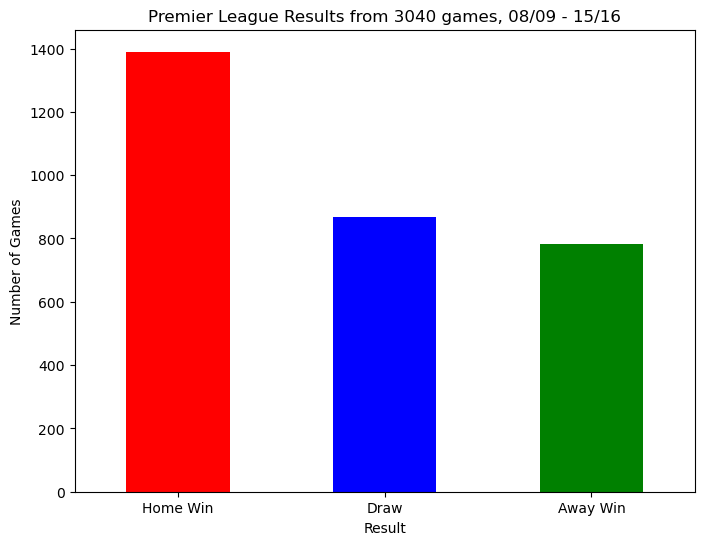

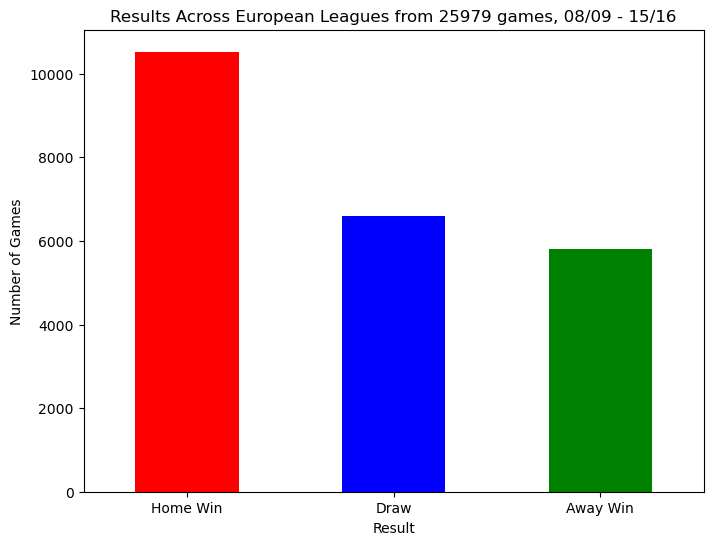

In [663]:
import matplotlib.pyplot as plt

# First figure for the 'prem' dataframe
plt.figure(figsize=(8, 6))
prem['Result'].value_counts().plot(kind='bar', color=['red', 'blue', 'green'])
plt.xticks(ticks=[0, 1, 2], labels=['Home Win', 'Draw', 'Away Win'], rotation=0)
plt.ylabel('Number of Games')
plt.title('Premier League Results from 3040 games, 08/09 - 15/16')
plt.show()

# Second figure for the 'all_matches' dataframe
plt.figure(figsize=(8, 6))
european_matches['Result'].value_counts().plot(kind='bar', color=['red', 'blue', 'green'])
plt.xticks(ticks=[0, 1, 2], labels=['Home Win', 'Draw', 'Away Win'], rotation=0)
# label y axis with total number of games - 25979
plt.ylabel('Number of Games')

# title - Results Across European Leagues from 25979 games, 08/09 - 15/16
plt.title('Results Across European Leagues from 25979 games, 08/09 - 15/16')
plt.show()


In [664]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Count the number of occurrences of each result for 'prem'
prem_result_counts = prem['Result'].value_counts()
prem_labels = ['Home Win', 'Draw', 'Away Win']
prem_values = [prem_result_counts[1], prem_result_counts[0], prem_result_counts[-1]]

# Count the number of occurrences of each result for 'all_matches'
european_matches_result_counts = european_matches['Result'].value_counts()
european_matches_labels = ['Home Win', 'Draw', 'Away Win']
european_matches_values = [european_matches_result_counts[1], european_matches_result_counts[0], european_matches_result_counts[-1]]

# Create a subplot figure with two pie charts
fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type': 'domain'}, {'type': 'domain'}]],
    subplot_titles=[
    'Premier League Results, 3040 games, 08/09 - 15/16',
    'Europe (non-PL) Results, 22939 games, 08/09 - 15/16'
])

# Add the first pie chart (for 'prem')
fig.add_trace(
    go.Pie(
        labels=prem_labels,
        values=prem_values,
        hole=0.33,
        textinfo='label+percent',
        textposition='outside',
        showlegend=False
    ),
    row=1, col=1
)

# Add the second pie chart (for 'all_matches')
fig.add_trace(
    go.Pie(
        labels=european_matches_labels,
        values=european_matches_values,
        hole=0.33,
        textinfo='label+percent',
        textposition='outside',
        showlegend=False
    ),
    row=1, col=2
)

# Update the layout of the figure
fig.update_layout(title_text='Comparison of Match Results in England and rest of Europe', title_x=0.5)

# Show the figure
fig.show()


So we can see that Home Win is the most common result by far, almost twice as common as a draw and also far more likely than an Away Win.

These results in England and Europe are remarkably similar across tens of thousands of games in ten years. 

These are strong base rates. I will add these ad columns in the Prem dataframe for the model to see.

In [665]:
# add three columns - P(Home), P(Draw), P(Away) - the probability of each result
prem.insert(11, 'p(Home)', 0.457)
prem.insert(12, 'p(Draw)', 0.258)
prem.insert(13, 'p(Away)', 0.285)

Now we can compare the Margins - how are these distributed? What are specifically the most common results?

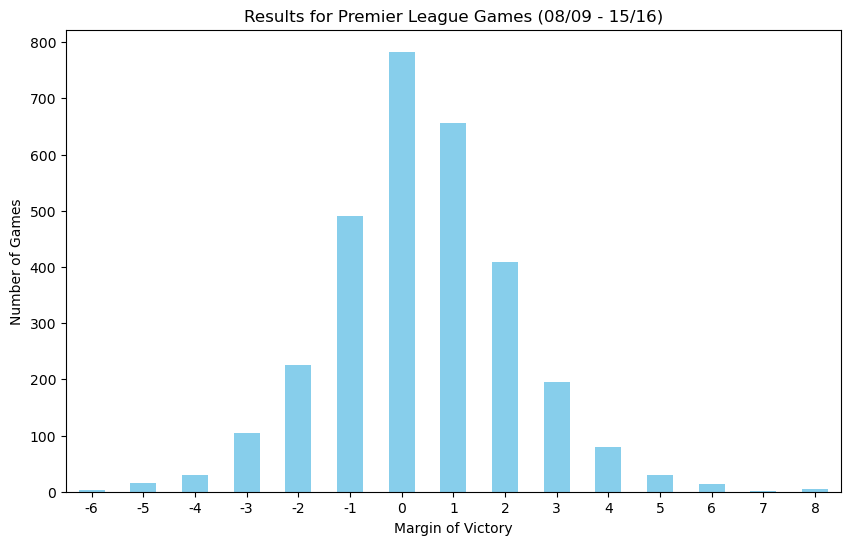

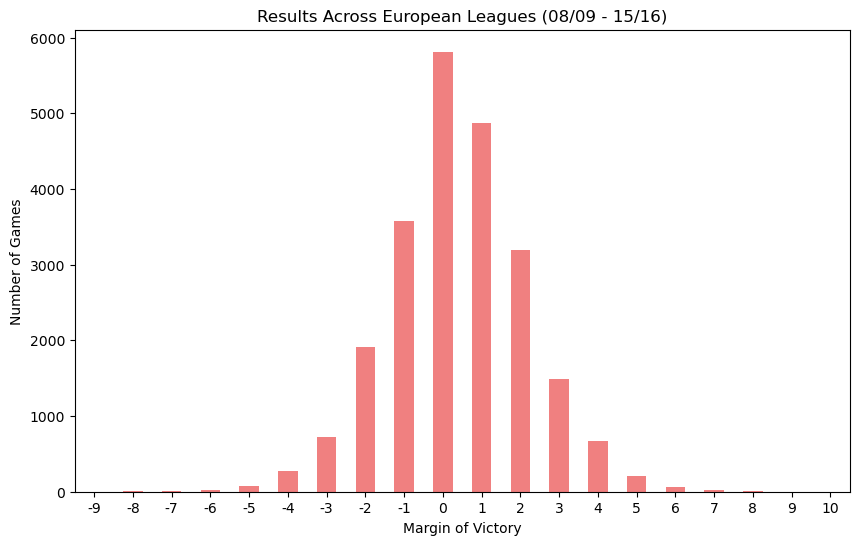

In [666]:
# First figure for the 'prem' dataframe
plt.figure(figsize=(10, 6))
prem['Margin'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Margin of Victory')
plt.ylabel('Number of Games')
plt.title('Results for Premier League Games (08/09 - 15/16)')
plt.xticks(rotation=0)
plt.show()

# Second figure for the 'all_matches' dataframe
plt.figure(figsize=(10, 6))
european_matches['Margin'].value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.xlabel('Margin of Victory')
plt.ylabel('Number of Games')
plt.title('Results Across European Leagues (08/09 - 15/16)')
plt.xticks(rotation=0)
plt.show()


Again, the results are remarkably similar! Bear in mind that 0 here represents *all draws*, not a 0-0 draw which is how all games begin, so the tendency of a home win by 1 goal is still quite close in frequency.

We will want to tease out 0-0 draws from 1-1 draws if we want to predict the Margin later on, but that is a Stretch goal.

For now, the previous few cells show that a Home Win is nearly twice as frequent as any other result with remarkable consistency across different European football leagues.

**Base Rates**
- Home Win: ~46%
- Away Win: ~28.5%
- Draw: ~ 25.5%

#### Conclusions of this section
- Home wins are clearly the most common result, and because every team is home and away an equal number of times, home field advantage is a factor in this.
- Now we need to find more specific features / data to help the predictive model

## Frequency of individual results (e.g. 1-0, 2-2), Premier League and Europe
- A home win is the most common general outcome, but which specific scorelines do we see the most? 
- If the match starts at 0-0, how common are specific draw scorelines?

In [667]:
# count every unique combination of home goals vs away goals
prem_goals = prem.groupby(['Home GS', 'Away GS']).size().reset_index(name='Count')
european_matches_goals = european_matches.groupby(['Home GS', 'Away GS']).size().reset_index(name='Count')
prem_goals.head(10)

,Home GS,Away GS,Count
0,0,0,251
1,0,1,213
2,0,2,120
3,0,3,72
4,0,4,23
5,0,5,11
6,0,6,3
7,1,0,308
8,1,1,317
9,1,2,205


In [668]:
# create "Final Score" column to show the result of the match
prem_goals['Final Score'] = prem_goals['Home GS'].astype(str) + ' - ' + prem_goals['Away GS'].astype(str)
european_matches_goals['Final Score'] = european_matches_goals['Home GS'].astype(str) + ' - ' + european_matches_goals['Away GS'].astype(str)

In [669]:
prem_goals[['Home GS', 'Away GS', 'Final Score', 'Count']].sample(5)

,Home GS,Away GS,Final Score,Count
1,0,1,0 - 1,213
4,0,4,0 - 4,23
18,2,4,2 - 4,13
29,4,2,4 - 2,23
46,8,0,8 - 0,3


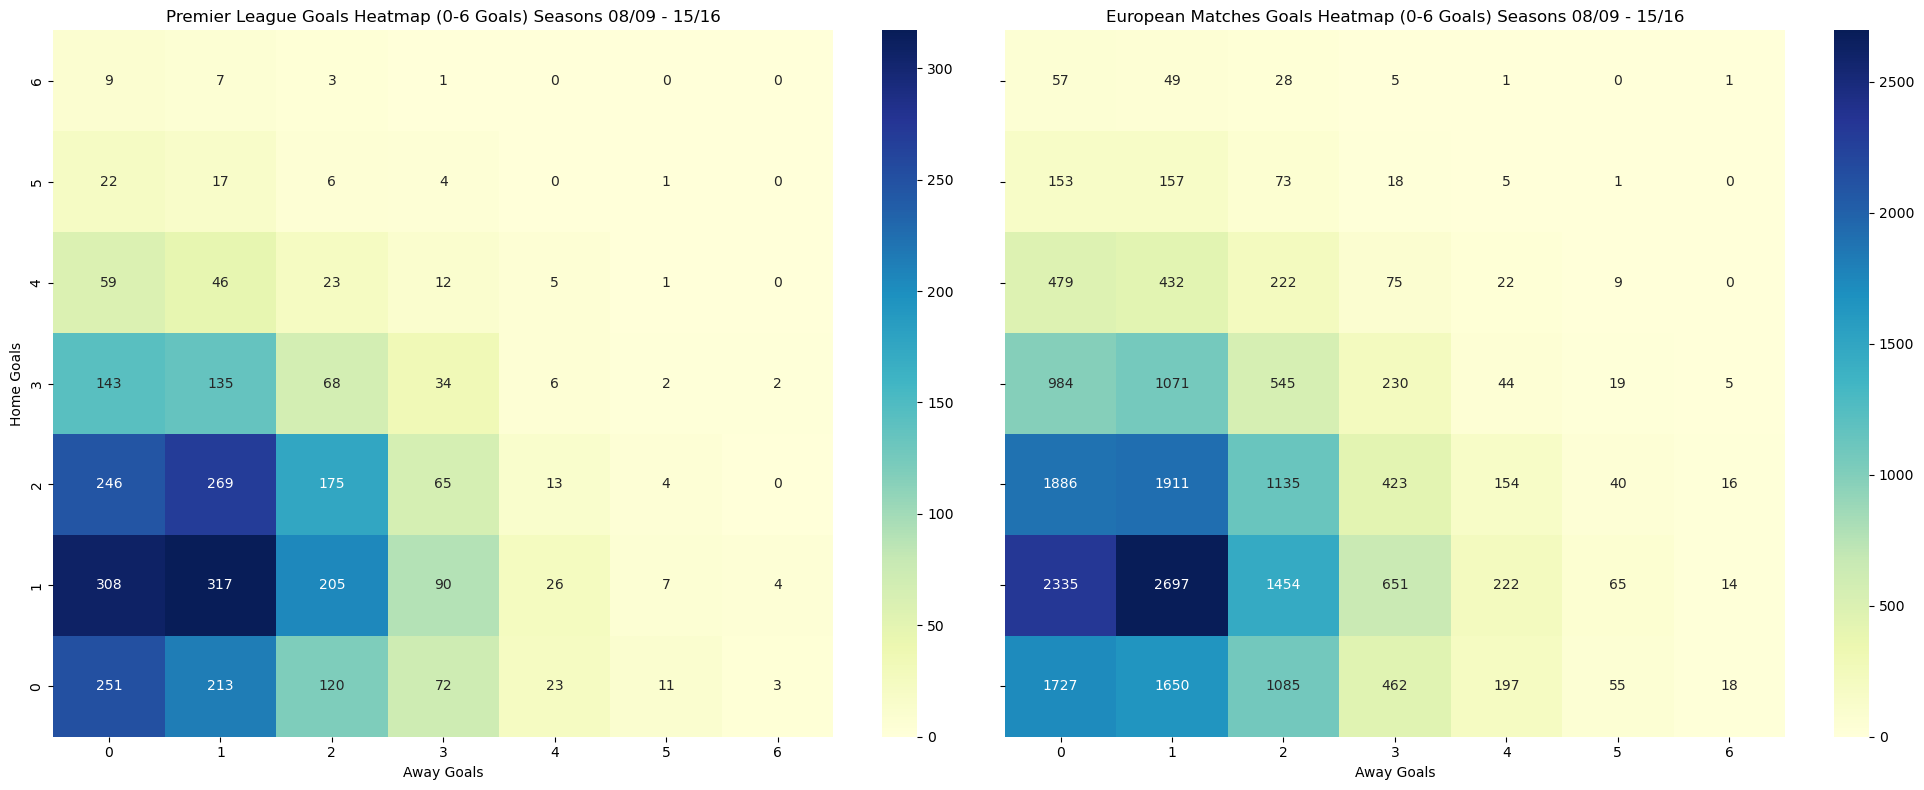

In [670]:
import numpy as np

# Define the range for Home GS and Away GS
goal_range = np.arange(0, 7)  # From 0 to 6 inclusive

# Filter the Premier League matrix to include only 0-6 goals
fixture_matrix = (
    prem_goals.pivot_table(
        index='Home GS',
        columns='Away GS',
        values='Count',
        aggfunc='sum',
        fill_value=0
    )
    .reindex(index=goal_range, columns=goal_range, fill_value=0)
)

# Filter the European Matches matrix to include only 0-6 goals
european_fixture_matrix = (
    european_matches_goals.pivot_table(
        index='Home GS',
        columns='Away GS',
        values='Count',
        aggfunc='sum',
        fill_value=0
    )
    .reindex(index=goal_range, columns=goal_range, fill_value=0)
)

# Reverse the order of rows and columns for both matrices to align (0, 0) in the bottom-left corner
fixture_matrix = fixture_matrix.iloc[::-1]
european_fixture_matrix = european_fixture_matrix.iloc[::-1]

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Heatmap for Premier League
sns.heatmap(
    fixture_matrix,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    cbar=True,
    ax=axes[0]
)
axes[0].set_title('Premier League Goals Heatmap (0-6 Goals) Seasons 08/09 - 15/16')
axes[0].set_xlabel('Away Goals')
axes[0].set_ylabel('Home Goals')

# Heatmap for European Matches
sns.heatmap(
    european_fixture_matrix,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    cbar=True,
    ax=axes[1]
)
axes[1].set_title('European Matches Goals Heatmap (0-6 Goals) Seasons 08/09 - 15/16')
axes[1].set_xlabel('Away Goals')
axes[1].set_ylabel('')  # No y-label on the second plot to avoid redundancy

# Adjust layout
plt.tight_layout()
plt.show()

so 1-1 is the most likely individual score followed by 1-0 (very closely in both!) and from eyeballing this, the % of results are also eerily close for both. 1-0 is a couple of percentage points behind 1-1 in both.

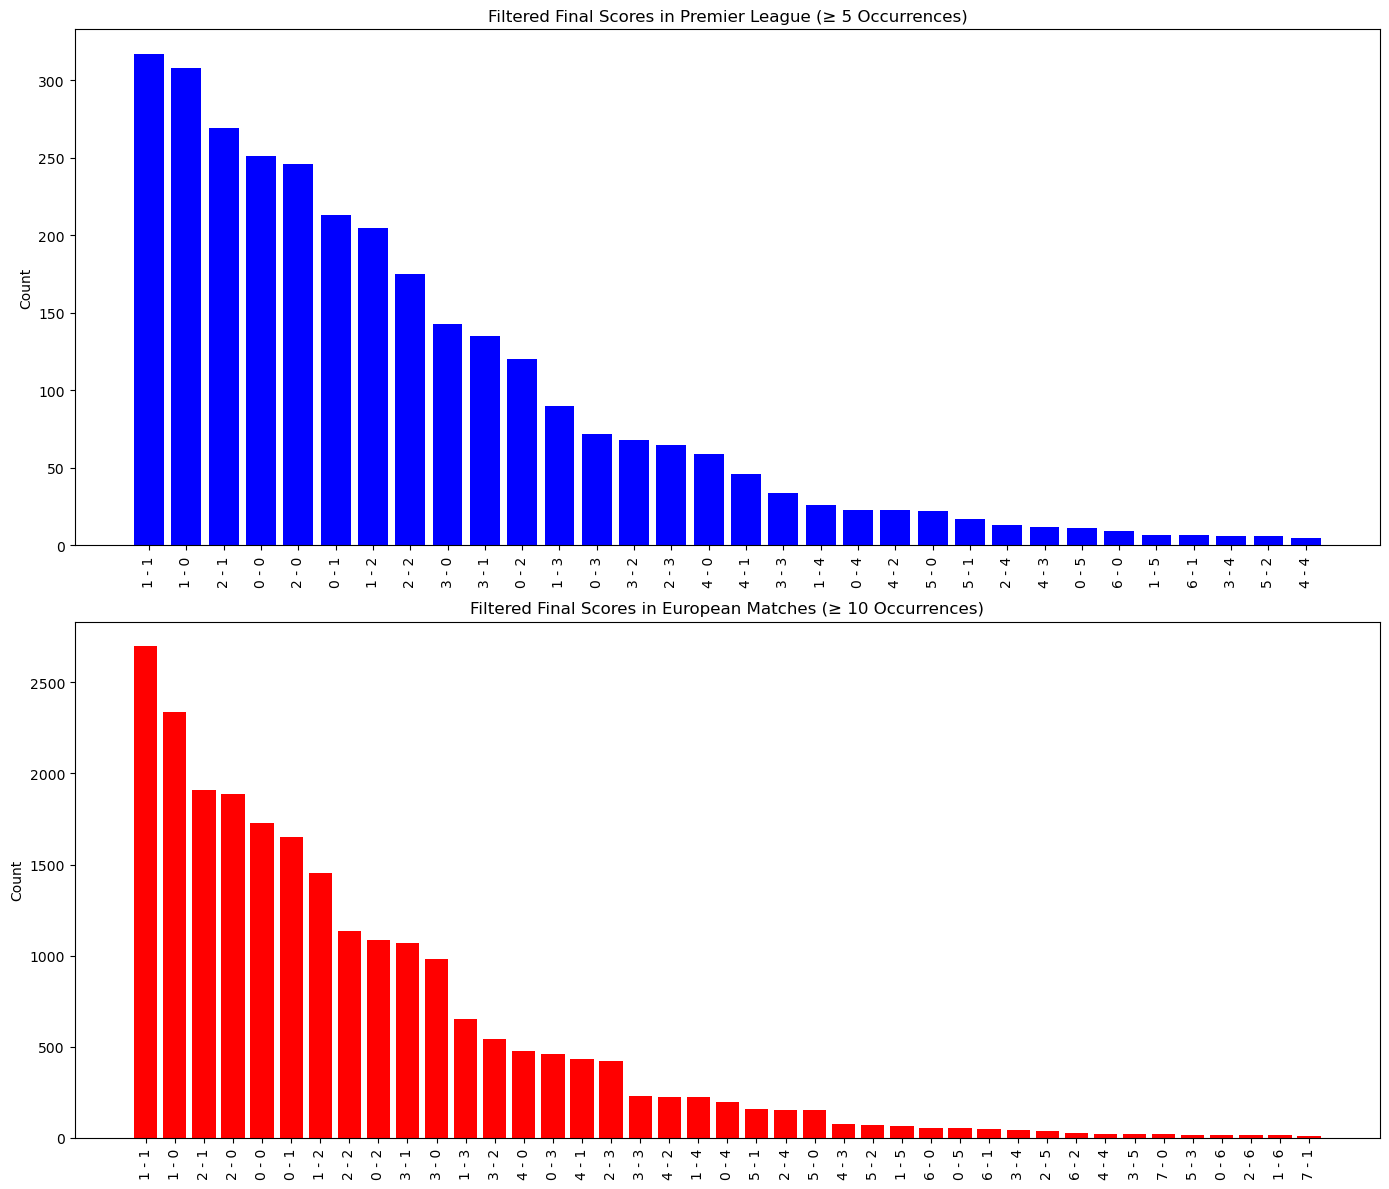

In [671]:
# Filter and sort the Premier League data - trim out the very rare scores
prem_filtered = prem_goals[prem_goals['Count'] >= 5].sort_values(by='Count', ascending=False)

# Filter and sort the European Matches data - trim out the very rare scores
european_filtered = european_matches_goals[european_matches_goals['Count'] >= 10].sort_values(by='Count', ascending=False)

# Create subplots for the filtered bar charts
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

# Bar chart for Premier League
axes[0].bar(prem_filtered['Final Score'], prem_filtered['Count'], color='blue')
axes[0].set_title('Filtered Final Scores in Premier League (≥ 5 Occurrences)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

# Bar chart for European Matches
axes[1].bar(european_filtered['Final Score'], european_filtered['Count'], color='red')
axes[1].set_title('Filtered Final Scores in European Matches (≥ 10 Occurrences)')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Some differences starting to emerge now - but 1-1, 1-0 and 2-1 still in order the most common results! 0-0 and 2-0 are reversed in Europe and the Prem, but then 0-1, 1-2 and 2-2 are the next most frequent scores in both datasets.

Let's get a % pie chart for the results

In [672]:
import plotly.express as px

# Calculate total matches for each dataset
prem_total = prem_goals['Count'].sum()
european_total = european_matches_goals['Count'].sum()

# Filter and group results for Premier League
prem_goals['Percentage'] = prem_goals['Count'] / prem_total * 100
prem_filtered = prem_goals[prem_goals['Percentage'] >= 2]
prem_other = pd.DataFrame({
    'Final Score': ['Other < 2%'],
    'Count': [prem_goals[prem_goals['Percentage'] < 2]['Count'].sum()]
})
prem_pie_data = pd.concat([prem_filtered[['Final Score', 'Count']], prem_other])

# Filter and group results for European Matches
european_matches_goals['Percentage'] = european_matches_goals['Count'] / european_total * 100
european_filtered = european_matches_goals[european_matches_goals['Percentage'] >= 2]
european_other = pd.DataFrame({
    'Final Score': ['Other < 2%'],
    'Count': [european_matches_goals[european_matches_goals['Percentage'] < 2]['Count'].sum()]
})
european_pie_data = pd.concat([european_filtered[['Final Score', 'Count']], european_other])

# Pie chart for Premier League Final Scores
prem_pie = px.pie(
    prem_pie_data,
    names='Final Score',
    values='Count',
    title='How often does the result occur in 3,000 Premier League matches? (08/09 - 15/16)',
    hole=0.3
)
prem_pie.update_traces(textinfo='label+percent', textposition='outside')
prem_pie.show()

# Pie chart for European Matches Final Scores
european_pie = px.pie(
    european_pie_data,
    names='Final Score',
    values='Count',
    title='How often does the result occur in 22,000 European league matches? (08/09 - 15/16)',
    hole=0.3
)
european_pie.update_traces(textinfo='label+percent', textposition='outside')
european_pie.show()

#### Observations
- The frequency of results across these leagues is staggering! Many individual results are only a single percentage point off each other at most
- Many results are in the same order with less than a quarter of a percentage point off in frequency is very interesting. These give a good base rate of longer term trends we can see.
    - Perhaps later we'll check out if these base rates are changing over time (is home field advantage decreasing over time, for instance?)
- 1-1 is the most common result and in the larger European sample, it is even more so than the PL. 1-0 is next, followed by 2-1 about 1.5 percent down which is close by with 2-0. 
- 0-0 draws are the fourth (PL) or fifth (Europe) most common result and a little bit more frequent in the Premier League.

#### Statistics of higher scoring teams in games

- Another interesting observation here is how rare instances of teams scoring three goals in a game are. The most common instance of one team scoring 3 goals is 4.3 - 4.7%, with 3-0 and 3-1 to the home team, followed by 3-2 (2.38%)

From anecdotal / personal observations of the best teams that are capable of scoring 3 goals in a game consistently, and the tendency to create cagey matches when they play each other, I'd like to explore the teams that frequently score 3+ goals in a game and their number of draws.

## EDA of Specific results and teams
- Can we learn patterns from teams scoring or conceding 3 goals in a game, which are rare events?
- Does playing at home or away affect the teams that happen to score 3+ in a match? Does it affect some teams more?
- Can 3+ goal exploration enhance our away win predictions down the line?
- Are draws more frequent in the busy christmas period or late season, when players are fatigued?

Coming back after my first run of the model, I need to solve the model's ability to predict draws and be better at predicting away wins.

When I saw that 3-0 or 3-1 only occurs around 4.5% of the time in the section above, and it is one of the less common results, I thought there would be potential to pick out the 'top teams' that would be more favourable for away wins, which are the ones that more frequently score 3 goals in a single match. These are the teams with the ability to easily win their home games and an attritional low-quality match, which would be a draw for most teams, would more likely be a win for them.

In [673]:
# how many matches has every unique team played in the premier league
home_team_counts = prem['home_team'].value_counts()

away_team_counts = prem['away_team'].value_counts()
appearances = home_team_counts.add(away_team_counts, fill_value=0).sort_values(ascending=False)
appearances.sample(5)

Fulham                     228
Blackburn Rovers           152
Aston Villa                304
Wolverhampton Wanderers    114
Cardiff City                38
Name: count, dtype: int64

In [674]:
# find the value counts for each team for matches where the home team has scored 3 or more goals
home_3_gs = prem[prem['Home GS'] >= 3]['home_team'].value_counts()
away_3_gs = prem[prem['Away GS'] >= 3]['away_team'].value_counts()

print(home_3_gs.sample(5))
print("\n")
print(away_3_gs.sample(5))

home_team
Reading               3
Fulham               19
Blackpool             2
Chelsea              46
Tottenham Hotspur    35
Name: count, dtype: int64


away_team
Stoke City           5
Fulham               8
Leicester City       7
Newcastle United    10
Norwich City         5
Name: count, dtype: int64


I also want to see the porous teams - who is vulnerable at home and away?

In [675]:
home_3_ga = prem[prem['Away GS'] >= 3]['home_team'].value_counts()
away_3_ga = prem[prem['Home GS'] >= 3]['away_team'].value_counts()
print(home_3_ga.sample(5))
print("\n")
print(away_3_ga.sample(5))

home_team
Crystal Palace       9
Swansea City        14
Blackburn Rovers     6
Southampton          9
Everton             17
Name: count, dtype: int64


away_team
Queens Park Rangers    20
Crystal Palace          6
Wigan Athletic         25
Southampton            11
Manchester United      16
Name: count, dtype: int64


I ran the sample function to save scrolling but by removing .sample, you can see the full results.

From very high level you can see that teams just don't score 3+ goals away from home as much as at home. No surprises there. It looks like about twice as likely that a team will score 3+ at home than away, but some teams like Arsenal seem to be quite consistent in their tendency to produce these games (only a 20% dropoff away from home).

Let's check.

In [676]:
# Make a df with team name, appearances, home 3+ goals, away 3+ goals
three_goals = pd.DataFrame({
    'Appearances': appearances,
    'Home 3+ Goals': home_3_gs,
    'Away 3+ Goals': away_3_gs,
    'Home 3+ Goals Against': home_3_ga,
    'Away 3+ Goals Against': away_3_ga
})

In [677]:
# We'll create columns for the probability of scoring 3+ goals at home and away, dividing appearances by half
three_goals['p(Home 3+ Goals)'] = round(three_goals['Home 3+ Goals'] / (three_goals['Appearances'] / 2), 3)
three_goals['p(Away 3+ Goals)'] = round(three_goals['Away 3+ Goals'] / (three_goals['Appearances'] / 2), 3)
three_goals['p(Home 3+ Goals Against)'] = round(three_goals['Home 3+ Goals Against'] / (three_goals['Appearances'] / 2), 3)
three_goals['p(Away 3+ Goals Against)'] = round(three_goals['Away 3+ Goals Against'] / (three_goals['Appearances'] / 2), 3)

# fill na values with 0
three_goals = three_goals.fillna(0)

# make Home 3+ goals and Away 3+ goals integers
three_goals['Home 3+ Goals'] = three_goals['Home 3+ Goals'].astype(int)
three_goals['Away 3+ Goals'] = three_goals['Away 3+ Goals'].astype(int)
three_goals['Home 3+ Goals Against'] = three_goals['Home 3+ Goals Against'].astype(int)
three_goals['Away 3+ Goals Against'] = three_goals['Away 3+ Goals Against'].astype(int)

# Rename the Appearances column to seasons, and divide the values by 38 to get the number of seasons the team appeared in this period
three_goals = three_goals.rename(columns={'Appearances': 'Seasons'})
three_goals['Seasons'] = (three_goals['Seasons'] / 38)

In [678]:
# seasons column as int
three_goals['Seasons'] = three_goals['Seasons'].astype(int)

In [679]:
# just the teams with more than one season in the premier league
three_goals.sort_values(by='Seasons', ascending=False)

,Seasons,Home 3+ Goals,Away 3+ Goals,Home 3+ Goals Against,Away 3+ Goals Against,p(Home 3+ Goals),p(Away 3+ Goals),p(Home 3+ Goals Against),p(Away 3+ Goals Against)
Arsenal,8,50,39,10,20,0.329,0.257,0.066,0.132
Chelsea,8,46,38,13,15,0.303,0.250,0.086,0.099
Tottenham Hotspur,8,35,23,11,27,0.230,0.151,0.072,0.178
Sunderland,8,20,15,19,35,0.132,0.099,0.125,0.230
Stoke City,8,20,5,11,35,0.132,0.033,0.072,0.230
Aston Villa,8,20,12,17,39,0.132,0.079,0.112,0.257
Manchester City,8,69,34,13,15,0.454,0.224,0.086,0.099
Liverpool,8,48,38,7,29,0.316,0.250,0.046,0.191
Everton,8,34,20,17,19,0.224,0.132,0.112,0.125
Manchester United,8,60,35,10,16,0.395,0.230,0.066,0.105


I want to determine a few things here as I add these probability of 3 goals columns:
- The teams with less appearances (because they got relegated from the PL) still have lower probabilities of scoring 3+ goals
- the differential between home and away probability of 3 goals

I will do a correlation heatmap of the probabilities of 3+ goals home and away, with the appearances

In [680]:
# differential between home and away 3+ goals
three_goals['Difference GS'] = three_goals['p(Home 3+ Goals)'] - three_goals['p(Away 3+ Goals)']
three_goals['Difference GA'] = three_goals['p(Home 3+ Goals Against)'] - three_goals['p(Away 3+ Goals Against)']

In [681]:
three_goals.sample(10)

,Seasons,Home 3+ Goals,Away 3+ Goals,Home 3+ Goals Against,Away 3+ Goals Against,p(Home 3+ Goals),p(Away 3+ Goals),p(Home 3+ Goals Against),p(Away 3+ Goals Against),Difference GS,Difference GA
Crystal Palace,3,6,9,9,6,0.105,0.158,0.158,0.105,-0.053,0.053
Manchester United,8,60,35,10,16,0.395,0.230,0.066,0.105,0.165,-0.039
Burnley,2,2,4,7,14,0.053,0.105,0.184,0.368,-0.052,-0.184
Aston Villa,8,20,12,17,39,0.132,0.079,0.112,0.257,0.053,-0.145
Portsmouth,2,5,1,8,7,0.132,0.026,0.211,0.184,0.106,0.027
Norwich City,4,10,5,11,24,0.132,0.066,0.145,0.316,0.066,-0.171
Bournemouth,1,3,2,6,5,0.158,0.105,0.316,0.263,0.053,0.053
Arsenal,8,50,39,10,20,0.329,0.257,0.066,0.132,0.072,-0.066
Reading,1,3,1,5,7,0.158,0.053,0.263,0.368,0.105,-0.105
Liverpool,8,48,38,7,29,0.316,0.250,0.046,0.191,0.066,-0.145


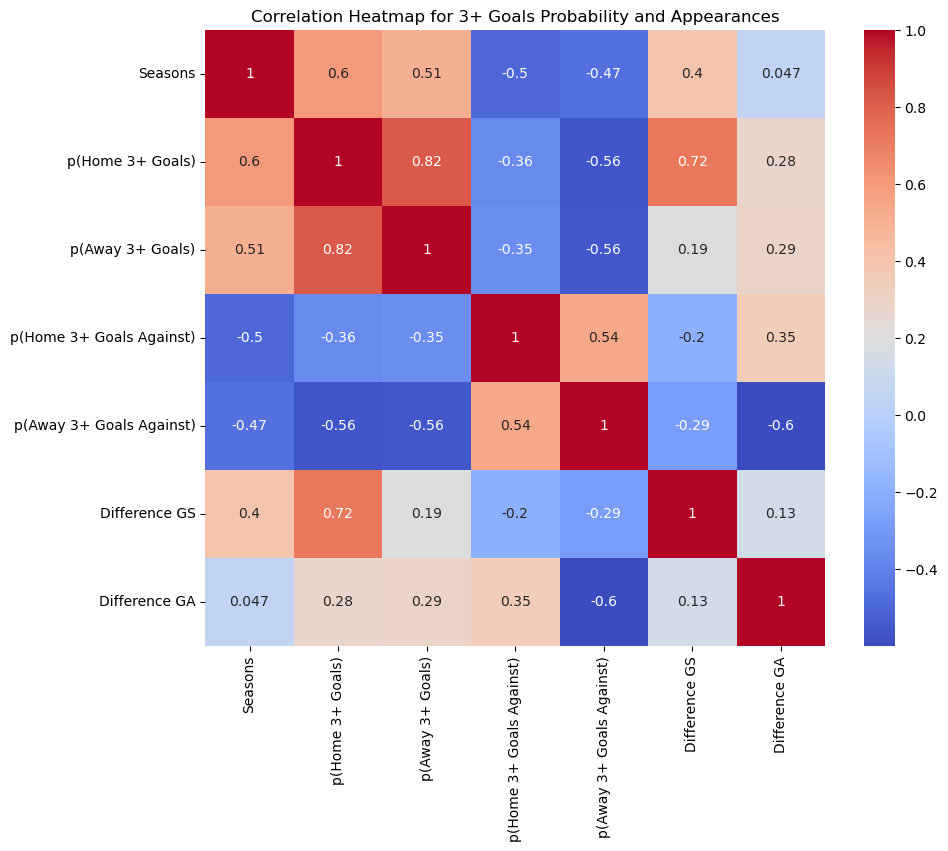

In [682]:
# correlation heatmap of the three_goals df with only the Appearance, p(Home 3+ Goals), p(Away 3+ Goals), and Difference columns
plt.figure(figsize=(10, 8))
sns.heatmap(three_goals[['Seasons', 'p(Home 3+ Goals)', 'p(Away 3+ Goals)', 'p(Home 3+ Goals Against)', 'p(Away 3+ Goals Against)', 'Difference GS', 'Difference GA']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for 3+ Goals Probability and Appearances')
plt.show()

There are a lot of strong correlations here:
- The strongest of which is p(home 3+) and p(away 3+) at 0.82. High scoring teams at home tend to also score a lot away, just on less occasions in absolute terms.
- Likewise, 0.54 corr between p(Home 3+ GA) and p(Away 3+ GA). Teams that concede a lot at home tend to also concede a lot away.
- Correlations with seasons:
    - As you might expect, fairly strong correlations between Seasons spent in the Prem and the tendency of scoring 3+ goals at home (0.6) and away (0.51)
    - In the same vein, fairly strong negative correlations between Seasons spent in the Prem and the tendency to concede 3+ goals at home (0.5) and away (0.47)
- Scoring 3 at home in a game is less negatively correlated to conceding 3 at home than conceding three away.    
    - This tells me the teams more regularly scoring 3 at home could also concede 3 at home more regularly than conceding three away.
- Ignoring the 0.6 Difference GA / p(Away 3+ GA as it's collinear)

Remember, unlike some of the other results based exploration, these are not symmetrical metrics. The individual teams outputs / performances in home and away games are recorded separately and conceptually different.

### Who built a fortress?
- Teams with the largest home / away 3+ goals differential
- Teams having noticeably better performance at home or away - good home form
- If you score 3 goals in a game, you will almost always win
- If you concede 3 goals in a game, you will almost always lose

In [683]:
# order the teams by the difference column
three_goals_gs = three_goals[['Seasons', 'Home 3+ Goals', 'Away 3+ Goals', 'p(Home 3+ Goals)', 'p(Away 3+ Goals)', 'Difference GS']].sort_values(by='Difference GS', ascending=False)
three_goals_gs

,Seasons,Home 3+ Goals,Away 3+ Goals,p(Home 3+ Goals),p(Away 3+ Goals),Difference GS
Manchester City,8,69,34,0.454,0.224,0.230
Manchester United,8,60,35,0.395,0.230,0.165
Southampton,4,18,8,0.237,0.105,0.132
Swansea City,5,19,7,0.200,0.074,0.126
Portsmouth,2,5,1,0.132,0.026,0.106
Reading,1,3,1,0.158,0.053,0.105
Cardiff City,1,3,1,0.158,0.053,0.105
Stoke City,8,20,5,0.132,0.033,0.099
Newcastle United,7,23,10,0.173,0.075,0.098
Fulham,6,19,8,0.167,0.070,0.097


In [684]:
# teams most likely to score 3+ goals at home
three_goals_gs.sort_values(by='p(Home 3+ Goals)', ascending=False).head(10)

,Seasons,Home 3+ Goals,Away 3+ Goals,p(Home 3+ Goals),p(Away 3+ Goals),Difference GS
Manchester City,8,69,34,0.454,0.224,0.230
Manchester United,8,60,35,0.395,0.230,0.165
Arsenal,8,50,39,0.329,0.257,0.072
Liverpool,8,48,38,0.316,0.250,0.066
Chelsea,8,46,38,0.303,0.250,0.053
Southampton,4,18,8,0.237,0.105,0.132
Tottenham Hotspur,8,35,23,0.230,0.151,0.079
Everton,8,34,20,0.224,0.132,0.092
Leicester City,2,8,7,0.211,0.184,0.027
Swansea City,5,19,7,0.200,0.074,0.126


In [685]:
# teams most likely to score three away from home
three_goals_gs.sort_values(by='p(Away 3+ Goals)', ascending=False).head(10)

,Seasons,Home 3+ Goals,Away 3+ Goals,p(Home 3+ Goals),p(Away 3+ Goals),Difference GS
Arsenal,8,50,39,0.329,0.257,0.072
Chelsea,8,46,38,0.303,0.250,0.053
Liverpool,8,48,38,0.316,0.250,0.066
Manchester United,8,60,35,0.395,0.230,0.165
Manchester City,8,69,34,0.454,0.224,0.230
Leicester City,2,8,7,0.211,0.184,0.027
Crystal Palace,3,6,9,0.105,0.158,-0.053
Tottenham Hotspur,8,35,23,0.230,0.151,0.079
Bolton Wanderers,4,13,11,0.171,0.145,0.026
Everton,8,34,20,0.224,0.132,0.092


Some insights:
- **Generally, all of the Big Six dominate the home and away 3+ goals leaderboards above** but some of them are noticeably better at home: 
    - The Manchester clubs are monstrous at home! They score 3+ goals at home significantly more than their nearest chasers Liverpool, Arsenal and Chelsea.
    - They are the highest differentials, City by a huge margin and United considerably ahead of third place, Southampton.
    - By Contrast, most of the other Big Six (Arsenal, Liverpool, Chelsea and Tottenham) slightly exceed the Manchester clubs' Away 3+ goals tallies, but not enough to fully compensate for the significantly higher prolific scoring at home in Manchester.

- There seems to be a bit of a ceiling of scoring 3+ goals away from home at 25% of the time.
- There are a few exceptions but generally the biggest differentials between home & away differentials were the mainstays in the premier league during this time (being there for all 8 seasons). 

However, with some specific domain knowledge, we should look at **trajectory** of the clubs over time too.
- With the departure of legendary manager Sir Alex Ferguson in May 2013, Manchester United entered a period of relative mediocrity and I would anticipate these prolific goalscoring tendencies to begin declining
- Manchester City were bought out by an Emirati billionaire in 2008 and since then have had significant investment putting them into an upward trajectory.

### Who gets humbled?

In [686]:
# order the teams by the difference column
three_goals_ga = three_goals[['Seasons', 'Home 3+ Goals Against', 'Away 3+ Goals Against', 'p(Home 3+ Goals Against)', 'p(Away 3+ Goals Against)', 'Difference GA']].sort_values(by='p(Away 3+ Goals Against)', ascending=False)
three_goals_ga

,Seasons,Home 3+ Goals Against,Away 3+ Goals Against,p(Home 3+ Goals Against),p(Away 3+ Goals Against),Difference GA
Blackpool,1,7,8,0.368,0.421,-0.053
Blackburn Rovers,4,6,29,0.079,0.382,-0.303
Burnley,2,7,14,0.184,0.368,-0.184
Cardiff City,1,5,7,0.263,0.368,-0.105
Reading,1,5,7,0.263,0.368,-0.105
Queens Park Rangers,3,7,20,0.123,0.351,-0.228
Norwich City,4,11,24,0.145,0.316,-0.171
Newcastle United,7,23,38,0.173,0.286,-0.113
Wolverhampton Wanderers,3,14,16,0.246,0.281,-0.035
Bournemouth,1,6,5,0.316,0.263,0.053


As you might expect the teams spending the least seasons in the PL have the higher probabilities of shipping 3+ goals. Is it more pronounced shipping home or away goals? 

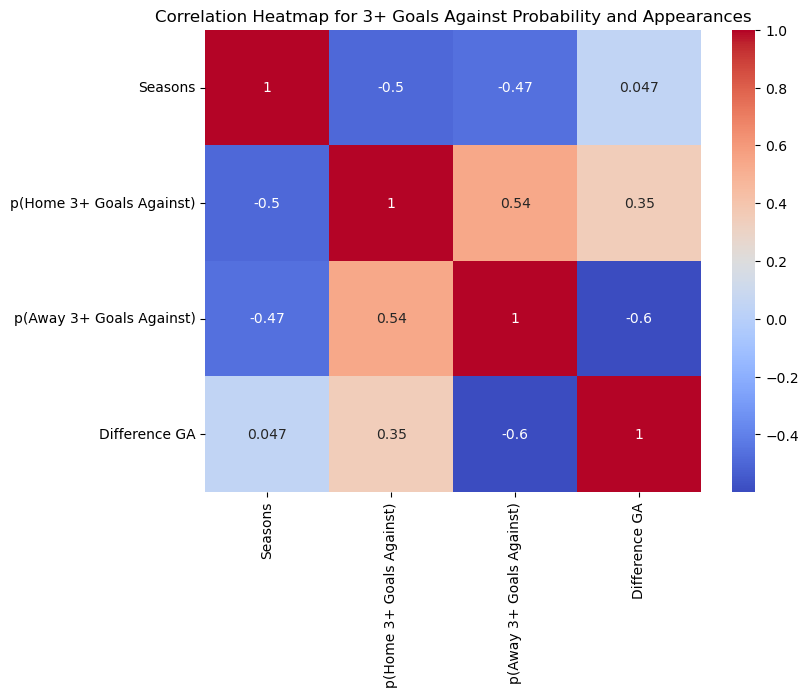

In [687]:
# correlation heatmap of three_goals_ga with seasons, p(Home 3+ Goals Against), p(Away 3+ Goals Against), and Difference GA
plt.figure(figsize=(8, 6))
sns.heatmap(three_goals_ga[['Seasons', 'p(Home 3+ Goals Against)', 'p(Away 3+ Goals Against)', 'Difference GA']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for 3+ Goals Against Probability and Appearances')
plt.show()

'Staying in the Premier League' is almost equally negatively correlated with the tendency to ship 3 at home or away, very slightly favouring this at home which makes sense - many small teams looking to survive build their survival on at least being hard to beat at home where they target the most wins.

### LEICESTER CITY:
- It's worth mentioning that one anomaly here is Leicester City. Leicester City won the title at the end of 2015-16 season, the last in the dataset. In the 2014-15 season, they narrowly avoided relegation. 
- They therefore have two seasons in this dataframe which are statistical Jekyll-and-Hyde, and thus we may want to have a feature that gives us points per game for the particular season, which would capture season-specific dynamics a particular team is going through.

They are a good exercise in seeing the same team having two very different seasons:

In [688]:
# find all games where Leicester City are the home team or the away team
leicester = prem[(prem['home_team'] == 'Leicester City') | (prem['away_team'] == 'Leicester City')]

# find the number of times Leicester City have scored 3+ goals in the 14/15 Season - backslash is for line continuation
leicester_3_gs_14_15 = leicester[(leicester['season'] == '14/15') & (leicester['Home GS'] >= 3) & (leicester['home_team'] == 'Leicester City')].shape[0] + \
                leicester[(leicester['season'] == '14/15') & (leicester['Away GS'] >= 3) & (leicester['away_team'] == 'Leicester City')].shape[0]

# number of times Leicester City conceded 3+ goals in the 14/15 season
leicester_3_ga_14_15 = leicester[(leicester['season'] == '14/15') & (leicester['Home GS'] >= 3) & (leicester['away_team'] == 'Leicester City')].shape[0] + \
                leicester[(leicester['season'] == '14/15') & (leicester['Away GS'] >= 3) & (leicester['home_team'] == 'Leicester City')].shape[0]

print(f'Leicester City scored 3+ goals in {leicester_3_gs_14_15} games and conceded 3+ goals in {leicester_3_ga_14_15} games in the 14/15 season.')

# find the number of times Leicester City have scored 3+ goals in the 15/16 Season
leicester_3_gs_15_16 = leicester[(leicester['season'] == '15/16') & (leicester['Home GS'] >= 3) & (leicester['home_team'] == 'Leicester City')].shape[0] + \
                leicester[(leicester['season'] == '15/16') & (leicester['Away GS'] >= 3) & (leicester['away_team'] == 'Leicester City')].shape[0]

# find the number of times Leicester City conceded 3+ goals in the 15/16 season
leicester_3_ga_15_16 = leicester[(leicester['season'] == '15/16') & (leicester['Home GS'] >= 3) & (leicester['away_team'] == 'Leicester City')].shape[0] + \
                leicester[(leicester['season'] == '15/16') & (leicester['Away GS'] >= 3) & (leicester['home_team'] == 'Leicester City')].shape[0]

print(f'Leicester City scored 3+ goals in {leicester_3_gs_15_16} games and conceded 3+ goals in {leicester_3_ga_15_16} games in the 15/16 season.')

Leicester City scored 3+ goals in 5 games and conceded 3+ goals in 6 games in the 14/15 season.
Leicester City scored 3+ goals in 10 games and conceded 3+ goals in 1 games in the 15/16 season.


Above: 14/15 was a survival season and 15/16 was a title-winning season

### Conclusions of this section:
- Scoring three at home or away will almost always get you the win, and most teams are better at home than away
- On the home form, Seasons correlates more strongly with home scoring and home conceding than it does with away - it's home form that keeps you winning and surviving in the Prem.
- Some teams are much more consistent in their tendency to score 3+ goals away or at home
- For those with the largest differential in home / away 3+ goals probability, its usually teams with outstanding home form

**What can we bring into the predictive model here?**
- % Home losses 
    - Captures how hard are this team to beat at home
    - Is the away team playing a good team or a good *home team*?
    - This rating could be predictive of good teams getting an away win or drawing.

## Points Per Game (ppg) 
- Overall PpG
- Find points per game in season so far, capturing current season's form?
- Points per game for last season, which will capture previous form and moving trajectory
- See how gradually teams change - e.g. Man City vs Man Utd

In [689]:
# variable created above: appaearances
appearances.sample(5)

Cardiff City       38
Crystal Palace    114
Wigan Athletic    190
Burnley            76
Reading            38
Name: count, dtype: int64

In [690]:
# number of wins, draws, and losses for each team
home_wins = prem[prem['Result'] == 1]['home_team'].value_counts()
away_wins = prem[prem['Result'] == -1]['away_team'].value_counts()
home_draws = prem[prem['Result'] == 0]['home_team'].value_counts()
away_draws = prem[prem['Result'] == 0]['away_team'].value_counts()
home_losses = prem[prem['Result'] == -1]['home_team'].value_counts()
away_losses = prem[prem['Result'] == 1]['away_team'].value_counts()

points = (home_wins * 3).add(away_wins * 3, fill_value=0).add(home_draws, fill_value=0).add(away_draws, fill_value=0)

# now create a dataframe with all the above data and appearances
pl_points = pd.DataFrame({
    'Appearances': appearances,
    'Home Wins': home_wins,
    'Away Wins': away_wins,
    'Home Draws': home_draws,
    'Away Draws': away_draws,
    'Home Losses': home_losses,
    'Away Losses': away_losses,
    'Points': points
})

In [691]:
pl_points.head()
# points per game column
pl_points['Points per Game'] = round(pl_points['Points'] / (pl_points['Appearances']), 2)
pl_points

,Appearances,Home Wins,Away Wins,Home Draws,Away Draws,Home Losses,Away Losses,Points,Points per Game
Arsenal,304,97,73,34,39,21,40,583,1.92
Aston Villa,304,45,41,50,38,57,73,346,1.14
Birmingham City,76,14,7,17,9,7,22,89,1.17
Blackburn Rovers,152,29,13,21,18,26,45,165,1.09
Blackpool,38,5,5,5,4,9,10,39,1.03
Bolton Wanderers,152,27,16,20,13,29,47,162,1.07
Bournemouth,38,5,6,5,4,9,9,42,1.11
Burnley,76,11,4,12,6,15,28,63,0.83
Cardiff City,38,5,2,5,4,9,13,30,0.79
Chelsea,304,101,75,34,36,17,41,598,1.97


Now we have an another easy way to see performance other than net_goals per game (which was influential in the first run, but this may be even more so)


In [692]:
prem.sample(5)

,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
2310,4039,14/15,2014-11-22,12,Arsenal,1,2,Manchester United,-1,-1,...,46509,30843,<goal><value><comment>o</comment><stats><owngo...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>54</comment><event...
1628,3357,12/13,2012-12-26,19,Stoke City,3,1,Liverpool,1,2,...,280276,40636,<goal><value><comment>p</comment><stats><penal...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>49</comment><event...
806,2535,10/11,2010-11-13,13,Wolverhampton Wanderers,2,3,Bolton Wanderers,-1,-1,...,23934,34261,<goal><value><comment>o</comment><stats><owngo...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>41</comment><event...
2560,4289,14/15,2015-05-02,35,Aston Villa,3,2,Everton,1,1,...,32705,181276,<goal><value><comment>n</comment><stats><goals...,<shoton><value><event_incident_typefk>157</eve...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><stats...
834,2563,10/11,2010-12-04,16,Blackburn Rovers,3,0,Wolverhampton Wanderers,1,3,...,23291,23538,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...


## Draws - when, who, why
- draws are the rarest of the three outcomes (Home, Draw, Away win) so our model will need something intelligent to predict them, otherwise it will guess at pure chance or always go for an away or home win
- Are draws more common in certain parts of the season? By top teams or weak teams?
- What else correlates with the tendency to draw games?

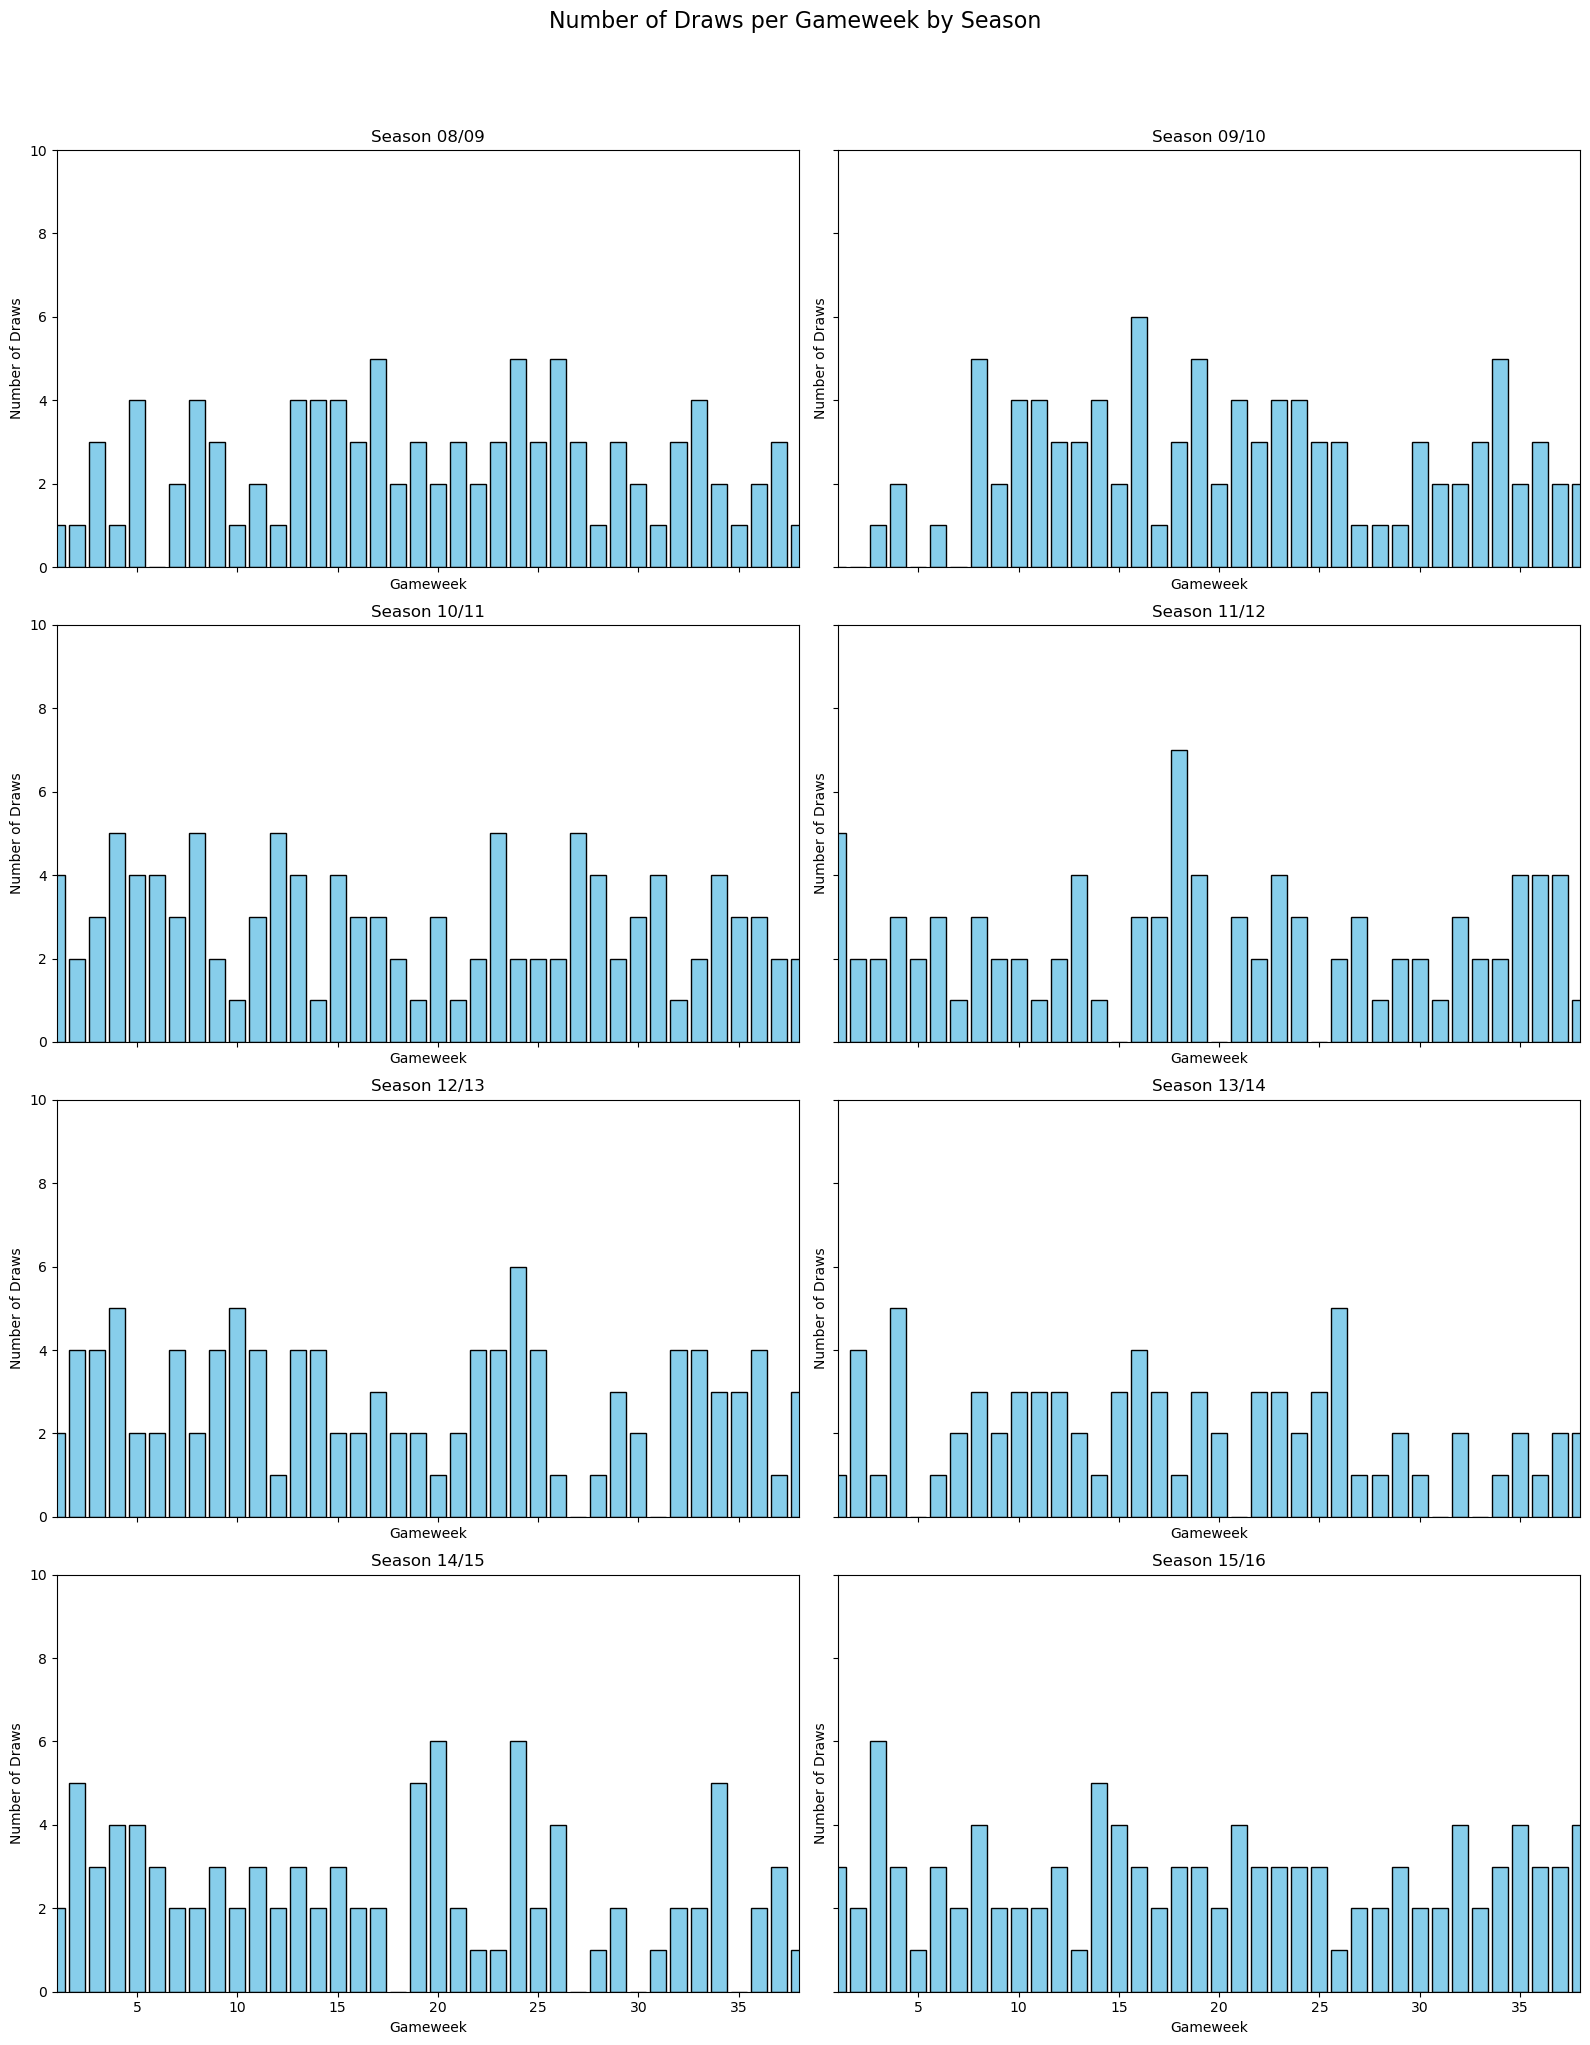

In [693]:
def plot_draws_per_gameweek(df):
    """
    Function to plot the frequency of draws per gameweek for each season.

    Parameters:
        data (pd.DataFrame): The input dataframe containing 'season', 'Gameweek / 38', and 'Result'.
    """
    import matplotlib.pyplot as plt

    # Ensure proper data types
    df['season'] = df['season'].astype(str)
    df['Gameweek / 38'] = df['Gameweek / 38'].astype(int)
    df['Result'] = df['Result'].astype(int)

    # Extract unique seasons
    seasons = df['season'].unique()

    # Initialize a figure with 8 subplots
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20), sharex=True, sharey=True)
    axes = axes.flatten()

    # Iterate through each season
    for idx, season in enumerate(seasons):
        ax = axes[idx]

        # Filter data for the current season
        season_data = df[df['season'] == season]

        # Count the number of draws (Result == 0) for each gameweek
        draws_per_gameweek = (
            season_data[season_data['Result'] == 0]
            .groupby('Gameweek / 38')
            .size()
            .reindex(range(1, 39), fill_value=0)  # Ensure all gameweeks (1 to 38) are present
        )

        # Plot the results
        ax.bar(draws_per_gameweek.index, draws_per_gameweek.values, color='skyblue', edgecolor='black')
        ax.set_title(f"Season {season}", fontsize=12)
        ax.set_xlim(1, 38)
        ax.set_ylim(0, 10)  # Maximum 10 matches per gameweek
        ax.set_xlabel('Gameweek')
        ax.set_ylabel('Number of Draws')

    # Adjust layout and display
    plt.tight_layout()
    plt.suptitle("Number of Draws per Gameweek by Season", fontsize=16, y=1.02)
    plt.subplots_adjust(top=0.95)
    plt.show()


# Test the function with the sample data
plot_draws_per_gameweek(prem)


Nothing really jumps out from above. If we aggregate the seasons and then look we might find something

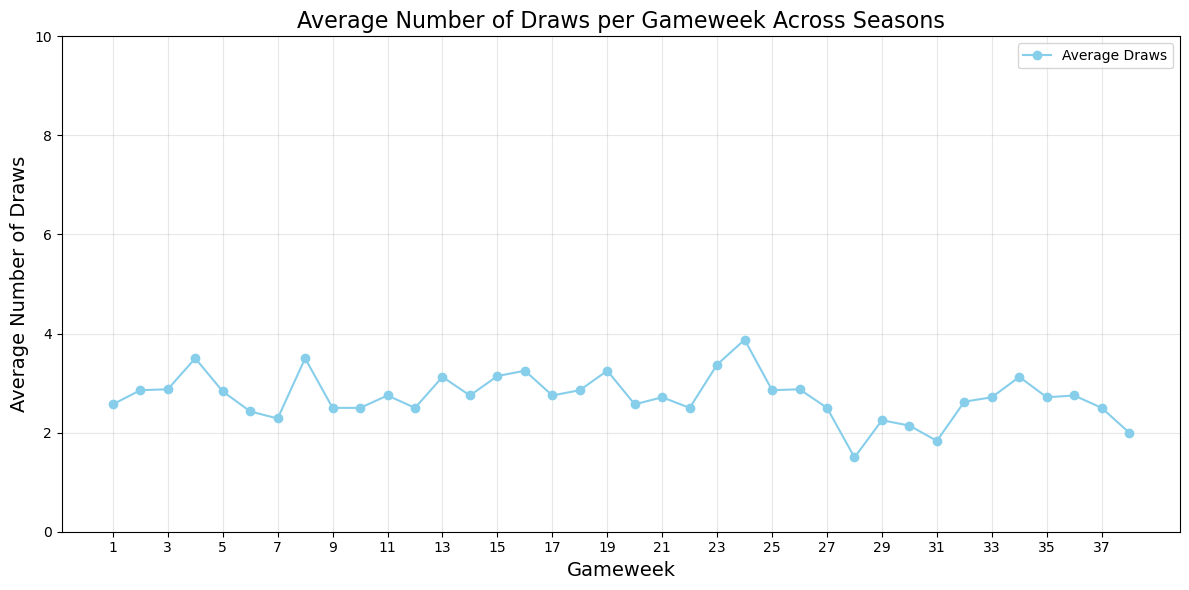

In [694]:
def plot_average_draws_per_gameweek(data):
    """
    Function to plot the average number of draws per gameweek across all seasons.

    Parameters:
        data (pd.DataFrame): The input dataframe containing 'season', 'Gameweek / 38', and 'Result'.
    """
    import matplotlib.pyplot as plt

    # Ensure proper data types
    data['season'] = data['season'].astype(str)
    data['Gameweek / 38'] = data['Gameweek / 38'].astype(int)
    data['Result'] = data['Result'].astype(int)

    # Count the number of draws (Result == 0) per gameweek for each season
    draws_per_gameweek = (
        data[data['Result'] == 0]
        .groupby(['season', 'Gameweek / 38'])
        .size()
        .reset_index(name='draw_count')
    )

    # Calculate the average number of draws per gameweek across all seasons
    average_draws = (
        draws_per_gameweek.groupby('Gameweek / 38')['draw_count']
        .mean()
        .reset_index(name='average_draws')
    )

    # Plot the average number of draws per gameweek
    plt.figure(figsize=(12, 6))
    plt.plot(
        average_draws['Gameweek / 38'], 
        average_draws['average_draws'], 
        marker='o', 
        linestyle='-', 
        color='skyblue', 
        label='Average Draws'
    )
    plt.title("Average Number of Draws per Gameweek Across Seasons", fontsize=16)
    plt.xlabel("Gameweek", fontsize=14)
    plt.ylabel("Average Number of Draws", fontsize=14)
    plt.ylim(0, 10)  # Reflecting the maximum number of matches per gameweek
    plt.xticks(range(1, 39, 2))  # Show every other gameweek for better readability
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Test the function with the sample data
plot_average_draws_per_gameweek(prem)


Again nothing really jumping out about draws being more common at certain points of the season. There is a **slight** increase into gameweeks 13 through 25 ish and general decline after, but this is marginal and it is still essentially two or three games per round end in a draw. 

**Who is drawing PL matches??**

I will use a dataframe pl_points I made below for points per game, to clearly show strong and weak teams, to do initial EDA

In [695]:
pl_points[pl_points['Appearances'] == 304]

,Appearances,Home Wins,Away Wins,Home Draws,Away Draws,Home Losses,Away Losses,Points,Points per Game
Arsenal,304,97,73,34,39,21,40,583,1.92
Aston Villa,304,45,41,50,38,57,73,346,1.14
Chelsea,304,101,75,34,36,17,41,598,1.97
Everton,304,76,45,43,57,33,50,463,1.52
Liverpool,304,86,64,43,33,23,55,526,1.73
Manchester City,304,113,62,18,43,21,47,586,1.93
Manchester United,304,116,76,16,41,20,35,633,2.08
Stoke City,304,69,29,43,43,40,80,380,1.25
Sunderland,304,49,29,47,45,56,78,326,1.07
Tottenham Hotspur,304,88,63,36,38,28,51,527,1.73


For fairness let's start by comparing the teams who spent all 8 seasons in the premier league (appearances = 304). We can do a correlation heatmap and scatter plot.

We obviously expect wins to correlate with ppg, but I want to see if draws correlate negatively or positively with ppg

What about finding the combined points per game between two teams, and checking the tendency of results? That would show if two big teams are more likely to draw than two weak teams

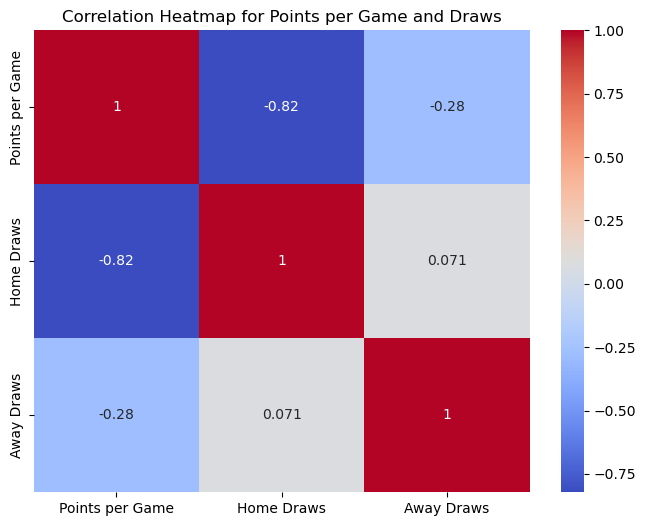

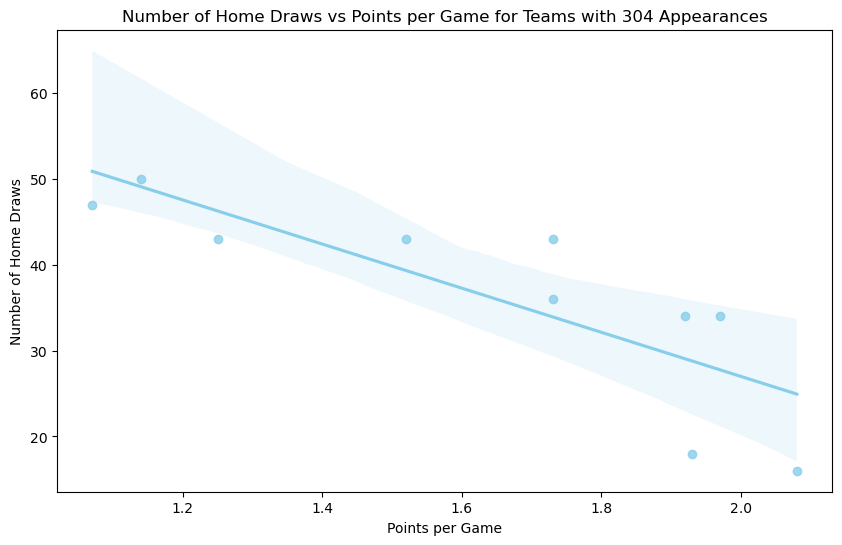

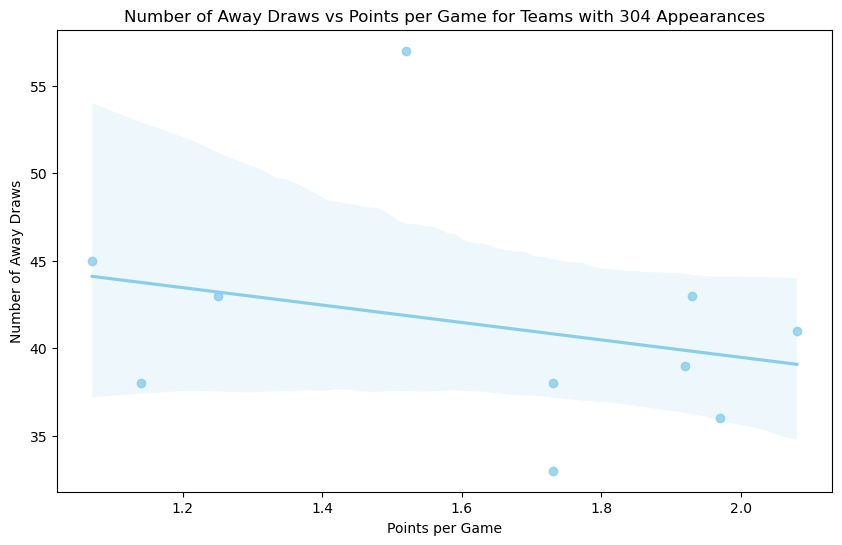

In [696]:
# create a subset of pl_points with only teams with 304 appearances
pl_points_304 = pl_points[pl_points['Appearances'] == 304]

# correlation heatmap of pl_points_304 with Points per Game, Home Draws, and Away Draws
plt.figure(figsize=(8, 6))
sns.heatmap(pl_points_304[['Points per Game', 'Home Draws', 'Away Draws']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Points per Game and Draws')
plt.show()


# plot the number of home draws, against points per game, add trendline
plt.figure(figsize=(10, 6))
sns.regplot(data=pl_points_304, x='Points per Game', y='Home Draws', color='skyblue')
plt.title('Number of Home Draws vs Points per Game for Teams with 304 Appearances')
plt.xlabel('Points per Game')
plt.ylabel('Number of Home Draws')
plt.show()


# plot the number of away draws combined, against points per game, add trendline
plt.figure(figsize=(10, 6))
sns.regplot(data=pl_points_304, x='Points per Game', y='Away Draws', color='skyblue')
plt.title('Number of Away Draws vs Points per Game for Teams with 304 Appearances')
plt.xlabel('Points per Game')
plt.ylabel('Number of Away Draws')
plt.show()

The anomaly in away draws with 57 is Everton - a Premier League stalwart and draw merchant that has been consistently average during this period!

We can see that home draws are strongly correlated against for teams with high ppg. this is probably just illustrating the 3 pt win / 1 pt draw gap, doubly important compared to the draw / loss points difference.

But this shows the average teams that survived the whole period vs the top teams that turned draws into wins, and the away draws also dry up at higher ppg.

Let's bring in the other teams and help compare them with probabilities based on total games

In [697]:
# create p(Home Win), p(Away Win), p(Home Draw), p(Away Draw), p(Home Loss), p(Away Loss) columns by dividing the respective columns by the number in the Appearances column
pl_points['p(Home Win)'] = pl_points['Home Wins'] / pl_points['Appearances']
pl_points['p(Away Win)'] = pl_points['Away Wins'] / pl_points['Appearances']
pl_points['p(Home Draw)'] = pl_points['Home Draws'] / pl_points['Appearances']
pl_points['p(Away Draw)'] = pl_points['Away Draws'] / pl_points['Appearances']
pl_points['p(Home Loss)'] = pl_points['Home Losses'] / pl_points['Appearances']
pl_points['p(Away Loss)'] = pl_points['Away Losses'] / pl_points['Appearances']


So we are trying to assess the different impact of home draws vs away draws. Conventional wisdom says a team drawing at home is 'dropping two points', a team drawing away is usually a good result. Even though both award 1 point

Correlation heatmap of ppg and home and away draws

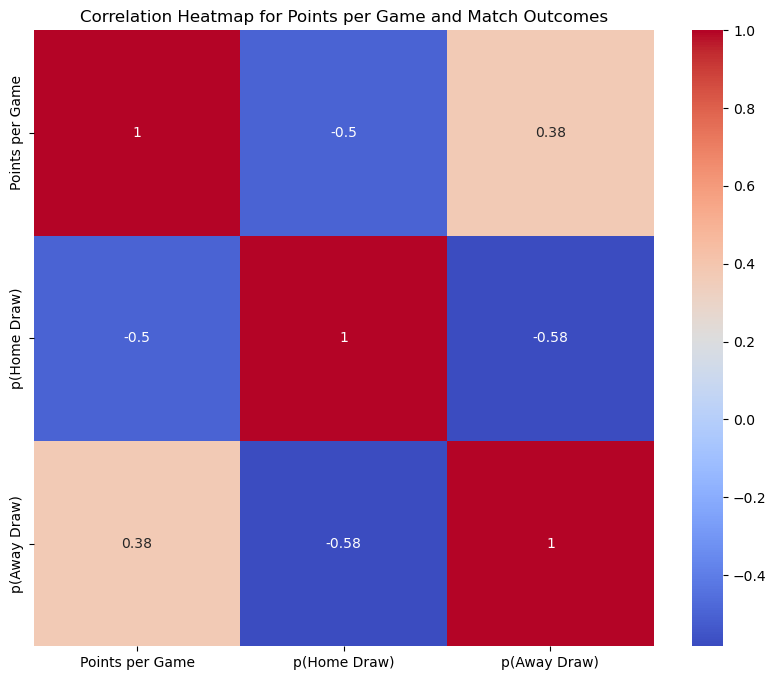

In [698]:
# correlation heatmap of pl_points with Points per Game, p(Home Win), p(Away Win), p(Home Draw), p(Away Draw), p(Home Loss), p(Away Loss)
plt.figure(figsize=(10, 8))
sns.heatmap(pl_points[['Points per Game', 'p(Home Draw)', 'p(Away Draw)']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Points per Game and Match Outcomes')
plt.show()

**Now we've added all PL appearing teams, p(away draw) is now moderately positively correlated +0.38 with PpG.** It was stronger in the negative correlation -0.5 with just the 10 Premier League mainstays.

For me, this shows that home draws are universally sub-optimal results but away draws are beneficial, and are of unique note to most teams that are not among the highest PpG

Now we'll plot the probability of draws against the points per game. We are looking more at the home away differentials, so we can overlay the two home and away

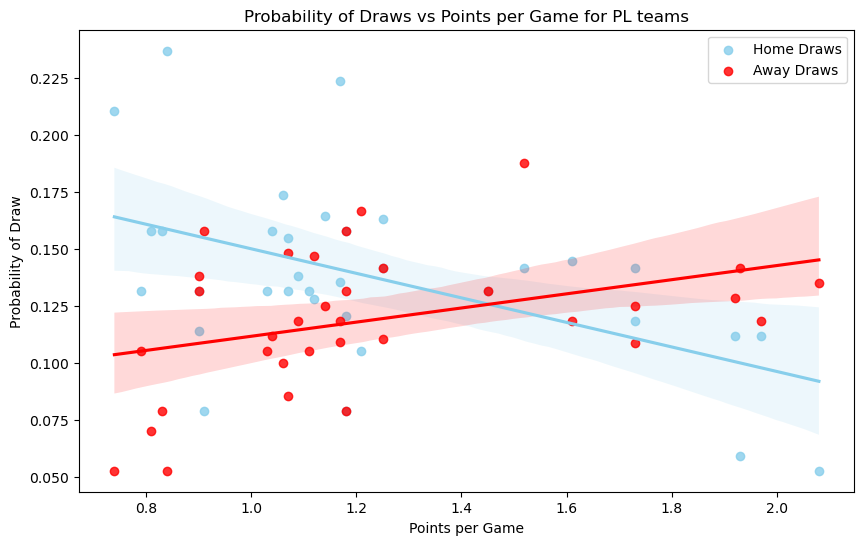

In [699]:
# plot the probability of home draws and probability of away draws against points per game, same figure and subplot, different colours, add trendlines for both
plt.figure(figsize=(10, 6))
sns.regplot(data=pl_points, x='Points per Game', y='p(Home Draw)', color='skyblue', label='Home Draws')
sns.regplot(data=pl_points, x='Points per Game', y='p(Away Draw)', color='red', label='Away Draws')
plt.title('Probability of Draws vs Points per Game for PL teams')
plt.xlabel('Points per Game')
plt.ylabel('Probability of Draw')
plt.legend()
plt.show()

This last graph shows the fundamentally different result an away draw is from a home draw, away wins being generally beneficial as teams improve losing away to grinding out a draw. Conversely, they work to turn home draws into wins.

Next we should look at **the probability of draws based on the quality of the home and away teams**. Answer questions like:
- Are top teams 1.6 PpG + drawing with each other more than weaker teams (0.8 - 1.1)?

Function below allows us to add home and away team points per game into the match data

In [700]:
def add_points_per_game(df, points):
    """
    Add points per game for home and away teams to the prem_draws dataframe.

    Parameters:
        prem_draws (pd.DataFrame): DataFrame containing match data with home and away team names.
        pl_points (pd.DataFrame): DataFrame with team names as the index and a 'Points per Game' column.

    Returns:
        pd.DataFrame: Updated prem_draws with 'home_team_ppg' and 'away_team_ppg' columns added.
    """
    # Merge home team points per game
    df = df.merge(
        points[['Points per Game']],
        how='left',
        left_on='home_team',  # Match the home team column
        right_index=True,  # Use the index of pl_points
        suffixes=('', '_home')
    ).rename(columns={'Points per Game': 'home_team_ppg'})

    # Merge away team points per game
    df = df.merge(
        points[['Points per Game']],
        how='left',
        left_on='away_team',  # Match the away team column
        right_index=True,  # Use the index of pl_points
        suffixes=('', '_away')
    ).rename(columns={'Points per Game': 'away_team_ppg'})

    return df

In [701]:
add_points_per_game(prem, pl_points).head()

,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin,...,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,home_team_ppg,away_team_ppg
0,1729,08/09,2008-08-17,1,Manchester United,1,1,Newcastle United,0,0,...,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...,2.08,1.17
1,1730,08/09,2008-08-16,1,Arsenal,1,0,West Bromwich Albion,1,1,...,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...,1.92,1.12
2,1731,08/09,2008-08-16,1,Sunderland,0,1,Liverpool,-1,-1,...,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...,1.07,1.73
3,1732,08/09,2008-08-16,1,West Ham United,2,1,Wigan Athletic,1,1,...,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...,1.18,1.06
4,1733,08/09,2008-08-17,1,Aston Villa,4,2,Manchester City,1,2,...,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...,1.14,1.93


In [702]:
prem = add_points_per_game(prem, pl_points)

In [703]:
prem.sample(5)

,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin,...,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,home_team_ppg,away_team_ppg
1840,3569,12/13,2012-09-15,4,Arsenal,6,1,Southampton,1,5,...,<goal><value><comment>o</comment><stats><owngo...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>57</comment><event...,1.92,1.45
441,2170,09/10,2009-12-05,15,West Ham United,0,4,Manchester United,-1,-4,...,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>36</comment><event...,1.18,2.08
1335,3064,11/12,2012-03-03,27,Queens Park Rangers,1,1,Everton,0,0,...,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><event_incident_typefk>595</ev...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><event_incident_typefk>123</even...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>52</comment><event...,0.81,1.52
1744,3473,12/13,2012-09-02,3,Southampton,2,3,Manchester United,-1,-1,...,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>37</comment><event...,1.45,2.08
2410,4139,14/15,2015-01-11,21,Arsenal,3,0,Stoke City,1,3,...,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...,1.92,1.25


I now want to see if there are more draws among weaker or stronger teams playing each other. 

A scatter plot would be good here because clustering will be easily visible, each point represents a draw. It would reveal clusters if draws tend to happen with a weak home / strong away team, strong home and away teams or weak home and away teams. I will also do a heat map.

However, we need to normalize matches based on PPG first - there are more average teams than top teams, so we are going to observe more draws between average teams than top teams by sheer volume, not football related reasons.

We can use the full prem dataframe and the filtered prem dataframe with only draws. Then we'll divide the number of draws by the total number of matches in each category to find the **draw probability**

We can also bin or group teams by a PpG category:

- **<1 is Low** for relegation strugglers
- **1 - 1.4 is Medium** for mid table where 1.0 ppg is essentially safety from relegation, and 1.4 ppg is top half of the table, pushing for European places
- **1.4 - 1.8 is High**, European places and close to pushing for UCL

- **1.8+ is Elite**, UCL qualification and title chasing

In [704]:
# create a prem_draws subset of prem with only draws, where Result == 0
prem_draws = prem[prem['Result'] == 0]

In [705]:
def categorize_ppg(ppg, bins=[0, 1.0, 1.4, 1.8, float('inf')], labels=['Low', 'Medium', 'High', 'Elite']): 
    """
    Categorize points per game (PPG) into bins.
    """
    return pd.cut(ppg, bins=bins, labels=labels, right=False)

In [706]:
def calculate_draw_probabilities_normalized(prem, prem_draws):
    """
    Calculate the normalized probability of a draw for each combination of home and away PPG categories.

    Parameters:
        prem (pd.DataFrame): Full DataFrame containing all results with home and away PPG.
        prem_draws (pd.DataFrame): Subset DataFrame containing only draws.

    Returns:
        pd.DataFrame: DataFrame with probabilities of a draw for each PPG combination.
    """
    # Categorize PPG for both datasets
    prem['home_ppg_category'] = categorize_ppg(prem['home_team_ppg'])
    prem['away_ppg_category'] = categorize_ppg(prem['away_team_ppg'])
    prem_draws['home_ppg_category'] = categorize_ppg(prem_draws['home_team_ppg'])
    prem_draws['away_ppg_category'] = categorize_ppg(prem_draws['away_team_ppg'])

    # Count total matches for each PPG category combination
    total_matches = prem.groupby(['home_ppg_category', 'away_ppg_category']).size().reset_index(name='total_matches')

    # Count total draws for each PPG category combination
    total_draws = prem_draws.groupby(['home_ppg_category', 'away_ppg_category']).size().reset_index(name='total_draws')

    # Merge to calculate probabilities
    draw_stats = total_matches.merge(total_draws, on=['home_ppg_category', 'away_ppg_category'], how='left')
    draw_stats['total_draws'] = draw_stats['total_draws'].fillna(0)  # Fill NaN draws with 0
    draw_stats['draw_probability'] = draw_stats['total_draws'] / draw_stats['total_matches']

    return draw_stats


In [707]:
def visualize_draw_probabilities(draw_stats):
    """
    Visualize draw probabilities for each home and away PPG category combination.

    Parameters:
        draw_stats (pd.DataFrame): DataFrame with draw probabilities and PPG categories.

    Returns:
        None: Displays a heatmap with home team PPG on the x-axis and away team PPG on the y-axis.
    """
    # Pivot the data for heatmap
    heatmap_data = draw_stats.pivot(
        index='away_ppg_category',  # Away team PPG on the y-axis
        columns='home_ppg_category',  # Home team PPG on the x-axis
        values='draw_probability'
    )

    # reverse plotted one axis below - elite / elite is in the top right
    heatmap_data = heatmap_data.iloc[::-1, ::]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        cmap='Blues', 
        fmt='.2f', 
        linewidths=0.5, 
        cbar_kws={'label': 'Probability of Draw'}
    )
    plt.title("Normalized draw probability Based on Pts Per Game", fontsize=16)
    plt.xlabel("Home Team PPG Category", fontsize=14)
    plt.ylabel("Away Team PPG Category", fontsize=14)
    plt.tight_layout()
    plt.show()

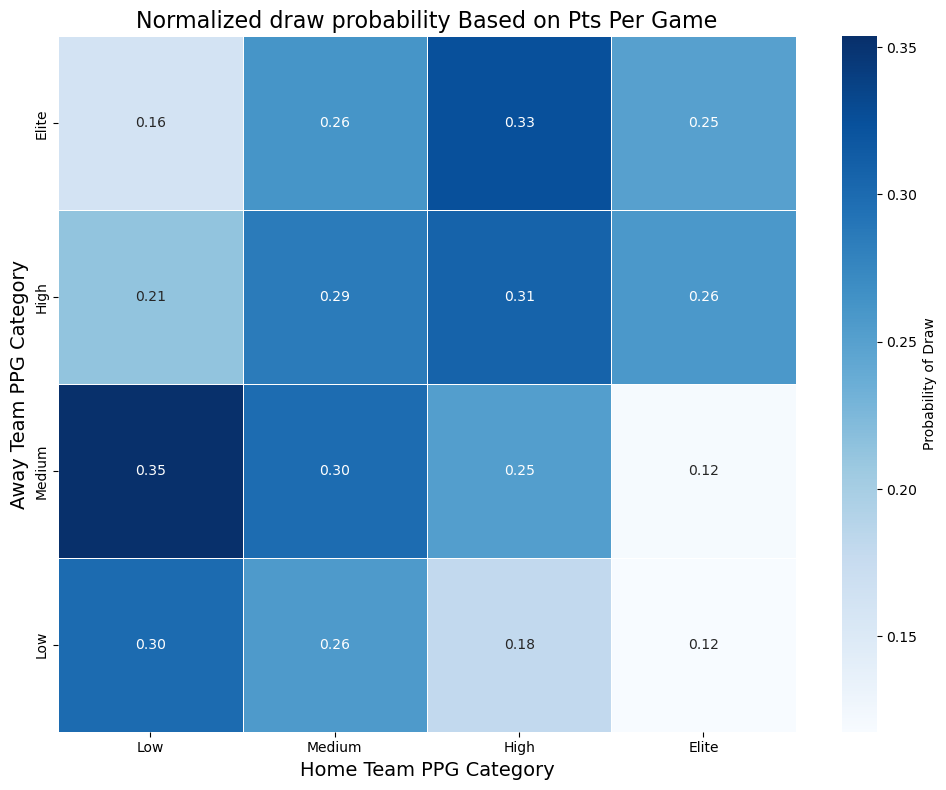

In [708]:
# Calculate draw probabilities
draw_stats = calculate_draw_probabilities_normalized(prem, prem_draws)

# Visualize the probabilities
visualize_draw_probabilities(draw_stats)

The general view above is that its slightly 'hotter' above the diagonal line than below it which reflects home field advantage leading to draws for weaker teams.
- For example in home/away matches between Low/Medium there's a 35% chance of a draw, Low/Low 30%, Med/Low 26%
- For matches between equal teams, Elite/Elite is actually the least likely to be a draw. High/Elite is 33% likely to be a draw.

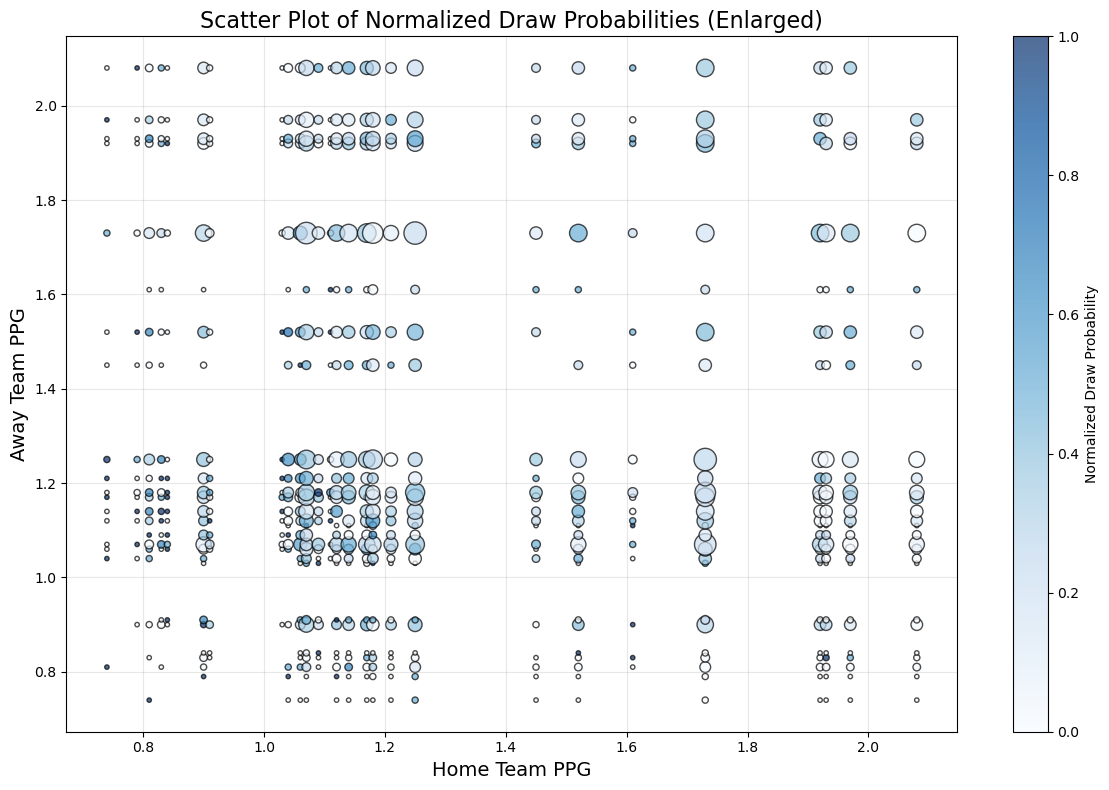

In [709]:
def plot_scatter_draw_probability(prem, prem_draws, size_factor=10):
    """
    Create a scatter plot for normalized draw probabilities based on home and away PPG.

    Parameters:
        prem (pd.DataFrame): Full DataFrame containing all results with home and away PPG.
        prem_draws (pd.DataFrame): Subset DataFrame containing only draws.
        size_factor (int): Factor to scale the size of the points (default: 50).

    Returns:
        None: Displays a scatter plot.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Count total matches
    total_matches = prem.groupby(['home_team_ppg', 'away_team_ppg']).size().reset_index(name='total_matches')

    # Count total draws
    total_draws = prem_draws.groupby(['home_team_ppg', 'away_team_ppg']).size().reset_index(name='total_draws')

    # Merge and normalize
    draw_stats = total_matches.merge(total_draws, on=['home_team_ppg', 'away_team_ppg'], how='left')
    draw_stats['total_draws'] = draw_stats['total_draws'].fillna(0)  # Fill NaN draws with 0
    draw_stats['draw_probability'] = draw_stats['total_draws'] / draw_stats['total_matches']

    # Check for non-empty data
    if draw_stats.empty:
        print("No data available for plotting.")
        return

    # Scale dot size by total matches and a size factor
    draw_stats['scaled_size'] = draw_stats['total_matches'] * size_factor

    # Create scatter plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        draw_stats['home_team_ppg'],
        draw_stats['away_team_ppg'],
        c=draw_stats['draw_probability'],  # Color by draw probability
        s=draw_stats['scaled_size'],  # Scaled size by total matches
        cmap='Blues',
        alpha=0.7,
        edgecolor='black'
    )
    plt.colorbar(scatter, label='Normalized Draw Probability')
    plt.title("Scatter Plot of Normalized Draw Probabilities (Enlarged)", fontsize=16)
    plt.xlabel("Home Team PPG", fontsize=14)
    plt.ylabel("Away Team PPG", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_scatter_draw_probability(prem, prem_draws)


#### Guide to above plot:
- **Point size = number of matches** for that PpG combination
    - The discrete lines it makes are because it's specific teams with that PpG across the 8 year period. We could make this more granular by giving the teams a more fluid PpG rather than one over the entire 8 year period
- **Dot colour = normalized draw probability**

- The dots appear in discrete lines up and across the graph because they represent the PpG average of each unique team during their entire stay in the PL data, however long that might be. That is probably why the darkest dots tend to be the smallest (1 matchup, 1 draw)

We can see a lot more white dots on the bottom right (weak away team, strong home team) than the top left (weak home team, stronger away team) so with this and the heatmap we can *generally* say that home field advatage compensates for a moderate gap in quality.

In [710]:
# delete the ppg_category columns now
prem = prem.drop(['home_ppg_category', 'away_ppg_category'], axis=1)

### Note on heatmap binning and discrete scatter plot above - it may be slightly misleading

The binning of teams by those PpG categories may cause some edge cases to magnify one bin over another. The scatter plot is also a little dense to read in its current state, as it's trying to balance out the larger sample size of matches between weaker teams compared to better ones.

Below is a density probability plot which can show the continuous shift more easily.

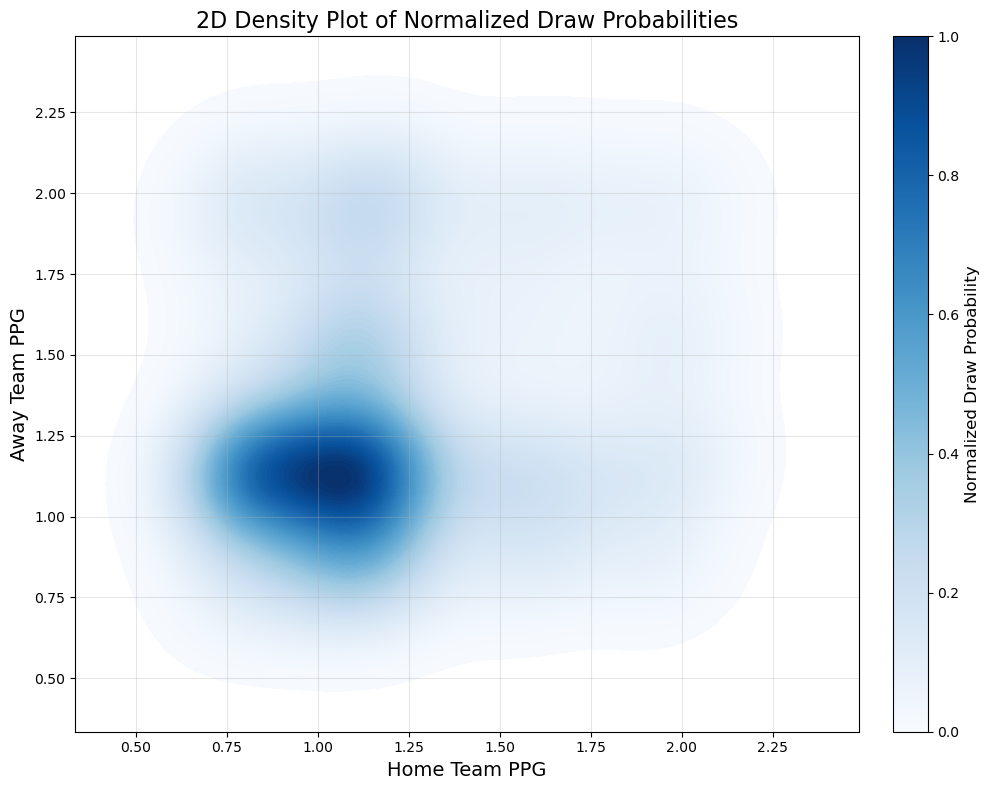

In [711]:
def plot_density_draw_probability(prem, prem_draws):
    """
    Create a 2D density plot for normalized draw probabilities based on home and away PPG.

    Parameters:
        prem (pd.DataFrame): Full DataFrame containing all results with home and away PPG.
        prem_draws (pd.DataFrame): Subset DataFrame containing only draws.

    Returns:
        None: Displays a 2D density plot with a color bar.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Count total matches
    total_matches = prem.groupby(['home_team_ppg', 'away_team_ppg']).size().reset_index(name='total_matches')

    # Count total draws
    total_draws = prem_draws.groupby(['home_team_ppg', 'away_team_ppg']).size().reset_index(name='total_draws')

    # Merge and normalize
    draw_stats = total_matches.merge(total_draws, on=['home_team_ppg', 'away_team_ppg'], how='left')
    draw_stats['total_draws'] = draw_stats['total_draws'].fillna(0)  # Fill NaN draws with 0
    draw_stats['draw_probability'] = draw_stats['total_draws'] / draw_stats['total_matches']

    # Check for non-empty data
    if draw_stats.empty:
        print("No data available for plotting.")
        return

    # Create a 2D density plot
    plt.figure(figsize=(10, 8))
    density = sns.kdeplot(
        x=draw_stats['home_team_ppg'],
        y=draw_stats['away_team_ppg'],
        weights=draw_stats['draw_probability'],
        cmap='Blues',
        fill=True,
        thresh=0.01,  # Slight threshold to remove insignificant regions
        levels=100
    )

    # Add color bar
    sm = plt.cm.ScalarMappable(cmap='Blues')
    sm.set_array(draw_stats['draw_probability'])
    cbar = plt.colorbar(sm, ax=density.get_figure().axes[-1], fraction=0.046, pad=0.04)
    cbar.set_label('Normalized Draw Probability', fontsize=12)

    # Plot adjustments
    plt.title("2D Density Plot of Normalized Draw Probabilities", fontsize=16)
    plt.xlabel("Home Team PPG", fontsize=14)
    plt.ylabel("Away Team PPG", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_density_draw_probability(prem, prem_draws)

It does seem like draws are more common at the lower end. 

The big cloud sits around 1.05 PpG Home - 1.15 PpG Away, approximately, with the drag left showing the home team's PpG can dip lower and still hold a slightly stronger opponent to a draw.

With the knowledge that it is noticeably when the home team is slightly weaker that draws are forced, and this seems to be true with a few angles of viewing this, we can engineer a **combined PpG of teams in a given match**.

We need to be careful to tease out the makeup of this combined statistic. Is the PpG made up of one excellent and one poor team, or two medium quality teams?

To pull this off we should use a PpG difference metric too.

In [712]:
def plot_combined_ppg_vs_ppg_difference(prem, prem_draws, size_factor=10):
    """
    Create a scatter plot of combined PPG vs PPG difference with draw probabilities.

    Parameters:
        prem (pd.DataFrame): Full DataFrame containing all results with home and away PPG.
        prem_draws (pd.DataFrame): Subset DataFrame containing only draws.
        size_factor (int): Factor to scale the size of the points (default: 50).

    Returns:
        Scatter Plot display.
    """
    import matplotlib.pyplot as plt

    # Count total matches
    total_matches = prem.groupby(['home_team_ppg', 'away_team_ppg']).size().reset_index(name='total_matches')

    # Count total draws
    total_draws = prem_draws.groupby(['home_team_ppg', 'away_team_ppg']).size().reset_index(name='total_draws')

    # Merge and normalize
    draw_stats = total_matches.merge(total_draws, on=['home_team_ppg', 'away_team_ppg'], how='left')
    draw_stats['total_draws'] = draw_stats['total_draws'].fillna(0)  # Fill NaN draws with 0
    draw_stats['draw_probability'] = draw_stats['total_draws'] / draw_stats['total_matches']

    # Create new features
    draw_stats['combined_ppg'] = draw_stats['home_team_ppg'] + draw_stats['away_team_ppg']
    draw_stats['ppg_difference'] = abs(draw_stats['home_team_ppg'] - draw_stats['away_team_ppg'])
    draw_stats['scaled_size'] = draw_stats['total_matches'] * size_factor

    # Scatter plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        draw_stats['combined_ppg'],
        draw_stats['ppg_difference'],
        c=draw_stats['draw_probability'],  # Color by draw probability
        s=draw_stats['scaled_size'],  # Size by total matches
        cmap='Blues',
        alpha=0.7,
        edgecolor='black'
    )
    plt.colorbar(scatter, label='Normalized Draw Probability')
    plt.title("Scatter Plot of Combined PPG vs PPG Difference", fontsize=16)
    plt.xlabel("Combined PPG (Home + Away)", fontsize=14)
    plt.ylabel("PPG Difference (|Home - Away|)", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

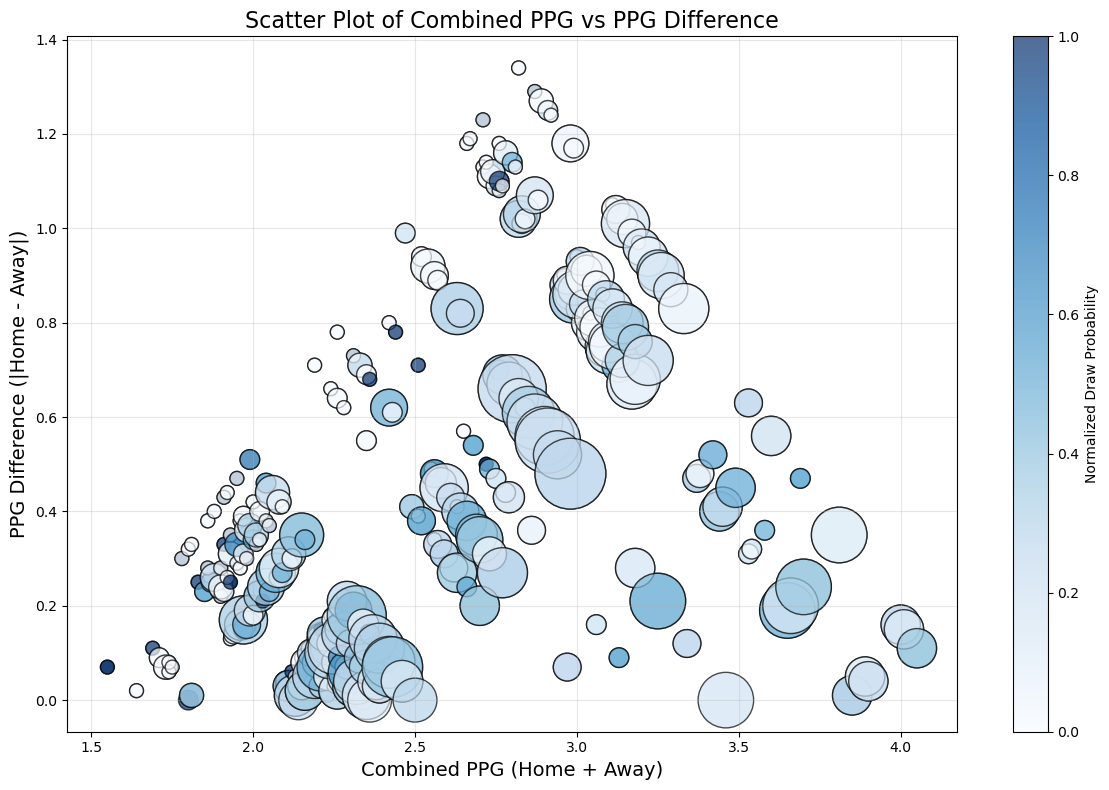

In [713]:
plot_combined_ppg_vs_ppg_difference(prem, prem_draws, size_factor=100)

### Conclusions from this section

It's been a little frustrating trying to tease out the general probability of draws based on the team's overall points per game, attempting through categorisation & binning, dealing with a varied sample size and visualisation to try to overcome that. 

Draws seem to be occasionally rare events that can pop up across the board, however we can say that draws tend to occur more with a slightly weaker home team compared to the away team, which combined with home field advantage can force stalemates.

## The team's form this season (PpG season, last 5 results)
The EDA around Leicester City having two completely different seasons in terms of performance shows that a lot of model performance will be in capturing the current season dynamics of the team. This can mean:
- Points per game so far this season, (for this season where gameweek is less than the current record, find the win/draw/losses of the team)
- Last 5 league results (how to encode this? Let's first try the sum of points in the last 5 games
- Try it first with ten games of one season in a small df

In [714]:
# trial small prem df for the function. All columns except season, date, gameweek / 38, home team, home gs, away gs, away team, result, margin 
prem_trial = prem[['season', 'date', 'Gameweek / 38', 'home_team', 'Home GS', 'Away GS', 'away_team', 'Result', 'Margin']]

# filter the dataframe so only season 15/16 is there
prem_trial = prem_trial[prem_trial['season'] == '15/16']

prem_trial.sort_values(by='date')

,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin
2661,15/16,2015-08-08,1,Bournemouth,0,1,Aston Villa,-1,-1
2662,15/16,2015-08-08,1,Chelsea,2,2,Swansea City,0,0
2663,15/16,2015-08-08,1,Everton,2,2,Watford,0,0
2664,15/16,2015-08-08,1,Leicester City,4,2,Sunderland,1,2
2665,15/16,2015-08-08,1,Manchester United,1,0,Tottenham Hotspur,1,1
...,...,...,...,...,...,...,...,...,...
2972,15/16,2016-05-15,38,Everton,3,0,Norwich City,1,3
2971,15/16,2016-05-15,38,Chelsea,1,1,Leicester City,0,0
2970,15/16,2016-05-15,38,Arsenal,4,0,Aston Villa,1,4
2975,15/16,2016-05-15,38,Southampton,4,1,Crystal Palace,1,3


Calculating Points per game and last 5 below:

In [715]:
def calculate_team_metrics(df):
    """
    Add columns for home and away team metrics ('ppg_season' and 'pts_last_5').

    Parameters:
        df (pd.DataFrame): DataFrame containing match data with 'season', 'Gameweek / 38',
                           'home_team', 'away_team', 'Home GS', and 'Away GS'.

    Returns:
        pd.DataFrame: Updated DataFrame with new columns:
                      'home_ppg_season', 'away_ppg_season', 'home_pts_last_5', 'away_pts_last_5'.
    """
    # Initialize new columns
    df['home_ppg_season'] = 0.0
    df['home_pts_last_5'] = 0
    df['away_ppg_season'] = 0.0
    df['away_pts_last_5'] = 0

    # Iterate over each unique season
    for season in df['season'].unique():
        season_df = df[df['season'] == season]
        print(f"Processing season: {season}...")

        # Create dictionaries to track points history for teams
        team_points = {team: [] for team in pd.concat([season_df['home_team'], season_df['away_team']]).unique()}

        # Iterate over records sorted by gameweek
        for _, row in season_df.sort_values(by='Gameweek / 38').iterrows():
            home_team = row['home_team']
            away_team = row['away_team']

            # Calculate points for the current match
            if row['Home GS'] > row['Away GS']:
                home_points = 3  # Home win
                away_points = 0  # Away loss
            elif row['Home GS'] == row['Away GS']:
                home_points = 1  # Draw
                away_points = 1  # Draw
            else:
                home_points = 0  # Home loss
                away_points = 3  # Away win

            # Calculate 'home_ppg_season'
            if len(team_points[home_team]) > 0:
                df.loc[row.name, 'home_ppg_season'] = sum(team_points[home_team]) / len(team_points[home_team])
            else:
                df.loc[row.name, 'home_ppg_season'] = 0.0  # No prior games

            # Calculate 'away_ppg_season'
            if len(team_points[away_team]) > 0:
                df.loc[row.name, 'away_ppg_season'] = sum(team_points[away_team]) / len(team_points[away_team])
            else:
                df.loc[row.name, 'away_ppg_season'] = 0.0  # No prior games

            # Calculate 'home_pts_last_5' (sum of last 5 games, excluding current match)
            df.loc[row.name, 'home_pts_last_5'] = sum(team_points[home_team][-5:])

            # Calculate 'away_pts_last_5' (sum of last 5 games, excluding current match)
            df.loc[row.name, 'away_pts_last_5'] = sum(team_points[away_team][-5:])

            # Append current match points to team points history
            team_points[home_team].append(home_points)
            team_points[away_team].append(away_points)

    # Round the columns after all calculations
    df['home_pts_last_5'] = df['home_pts_last_5'].round(2)
    df['away_pts_last_5'] = df['away_pts_last_5'].round(2)

    return df


In [716]:
calculate_team_metrics(prem_trial)

Processing season: 15/16...


,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5
2660,15/16,2015-08-09,1,Arsenal,0,2,West Ham United,-1,-2,0.000,0,0.000,0
2661,15/16,2015-08-08,1,Bournemouth,0,1,Aston Villa,-1,-1,0.000,0,0.000,0
2662,15/16,2015-08-08,1,Chelsea,2,2,Swansea City,0,0,0.000,0,0.000,0
2663,15/16,2015-08-08,1,Everton,2,2,Watford,0,0,0.000,0,0.000,0
2664,15/16,2015-08-08,1,Leicester City,4,2,Sunderland,1,2,0.000,0,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,15/16,2015-10-17,9,Southampton,2,2,Leicester City,0,0,1.500,10,1.875,8
3036,15/16,2015-10-19,9,Swansea City,0,1,Stoke City,-1,-1,1.250,5,1.125,7
3037,15/16,2015-10-17,9,Tottenham Hotspur,0,0,Liverpool,0,0,1.625,11,1.500,5
3038,15/16,2015-10-17,9,Watford,0,3,Arsenal,-1,-3,1.250,7,2.000,12


In [717]:
prem_trial.sample(10)

,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5
2964,15/16,2016-05-08,37,Liverpool,2,0,Watford,1,2,1.555556,8,1.222222,7
3027,15/16,2015-10-03,8,Norwich City,1,2,Leicester City,-1,-1,1.285714,6,1.714286,6
2912,15/16,2016-04-02,32,Bournemouth,0,4,Manchester City,-1,-4,1.225806,10,1.677419,5
3001,15/16,2015-09-19,6,Bournemouth,2,0,Sunderland,1,2,0.800000,4,0.400000,2
2885,15/16,2015-08-22,3,Norwich City,1,1,Stoke City,0,0,1.500000,3,0.500000,1
2897,15/16,2016-03-12,30,Stoke City,1,2,Southampton,-1,-1,1.482759,10,1.413793,7
2868,15/16,2016-03-02,28,Manchester United,1,0,Watford,1,1,1.629630,7,1.370370,8
2764,15/16,2015-12-28,19,Manchester United,0,0,Chelsea,0,0,1.611111,2,1.055556,5
2746,15/16,2015-12-19,17,Stoke City,1,2,Crystal Palace,-1,-1,1.437500,10,1.625000,10
2671,15/16,2015-10-24,10,Aston Villa,1,2,Swansea City,-1,-1,0.444444,0,1.111111,2


This looks great and seems ready for implementing on the main prem data!

In [718]:
calculate_team_metrics(prem)

Processing season: 08/09...
Processing season: 09/10...
Processing season: 10/11...
Processing season: 11/12...
Processing season: 12/13...
Processing season: 13/14...
Processing season: 14/15...
Processing season: 15/16...


,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin,...,card,cross,corner,possession,home_team_ppg,away_team_ppg,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5
0,1729,08/09,2008-08-17,1,Manchester United,1,1,Newcastle United,0,0,...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...,2.08,1.17,0.000,0,0.000,0
1,1730,08/09,2008-08-16,1,Arsenal,1,0,West Bromwich Albion,1,1,...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...,1.92,1.12,0.000,0,0.000,0
2,1731,08/09,2008-08-16,1,Sunderland,0,1,Liverpool,-1,-1,...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...,1.07,1.73,0.000,0,0.000,0
3,1732,08/09,2008-08-16,1,West Ham United,2,1,Wigan Athletic,1,1,...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...,1.18,1.06,0.000,0,0.000,0
4,1733,08/09,2008-08-17,1,Aston Villa,4,2,Manchester City,1,2,...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...,1.14,1.93,0.000,0,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,4764,15/16,2015-10-17,9,Southampton,2,2,Leicester City,0,0,...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>54</comment><stats...,1.45,1.61,1.500,10,1.875,8
3036,4765,15/16,2015-10-19,9,Swansea City,0,1,Stoke City,-1,-1,...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>53</comment><stats...,1.25,1.25,1.250,5,1.125,7
3037,4766,15/16,2015-10-17,9,Tottenham Hotspur,0,0,Liverpool,0,0,...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><stats...,1.73,1.73,1.625,11,1.500,5
3038,4767,15/16,2015-10-17,9,Watford,0,3,Arsenal,-1,-3,...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>39</comment><stats...,1.18,1.92,1.250,7,2.000,12


In [719]:
# using prem, create a subset of matches gameweek 10 and onward - momentum for season established
prem_momentum = prem[prem['Gameweek / 38'] >= 10]

In [720]:
# create a pts_last_5_diff column by subtracting away_pts_last_5 from home_pts_last_5
prem_momentum['pts_last_5_diff'] = prem_momentum['home_pts_last_5'] - prem_momentum['away_pts_last_5']


Above: we create a column to compare the recent form of the home and away team, the difference in points gained in last 5 games. 

Below we heatmap this to show correlation between the difference and result. We can also add in the home and away team's individual form - maybe home form is more influential than away form, or vice versa?

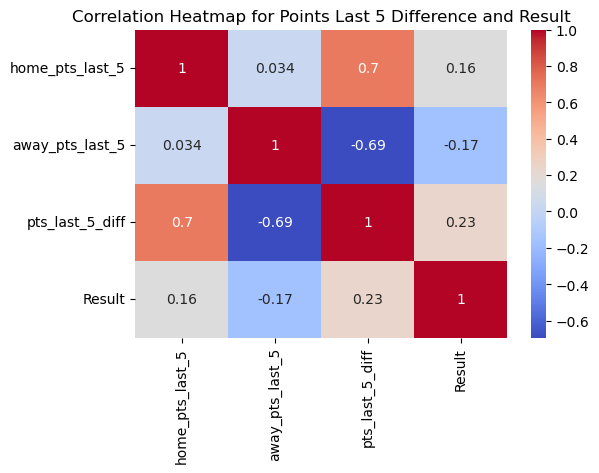

In [721]:
# correlation between pts_last_5_diff and result
plt.figure(figsize=(6, 4))
sns.heatmap(prem_momentum[['home_pts_last_5', 'away_pts_last_5','pts_last_5_diff', 'Result']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Points Last 5 Difference and Result')
plt.show()

There is some obvious collinearity in the home/away teams points and the differential, but we can see the differential with 0.23 correlation with the result, and almost equal (0.16 and -0.17) correlation in opposite direction for home and away form.

The last 5 games for both sides, and the differential should be taken forward in the prem dataframe

In [722]:
prem['pts_last_5_diff'] = prem['home_pts_last_5'] - prem['away_pts_last_5']


In [723]:
prem

,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin,...,cross,corner,possession,home_team_ppg,away_team_ppg,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff
0,1729,08/09,2008-08-17,1,Manchester United,1,1,Newcastle United,0,0,...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...,2.08,1.17,0.000,0,0.000,0,0
1,1730,08/09,2008-08-16,1,Arsenal,1,0,West Bromwich Albion,1,1,...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...,1.92,1.12,0.000,0,0.000,0,0
2,1731,08/09,2008-08-16,1,Sunderland,0,1,Liverpool,-1,-1,...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...,1.07,1.73,0.000,0,0.000,0,0
3,1732,08/09,2008-08-16,1,West Ham United,2,1,Wigan Athletic,1,1,...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...,1.18,1.06,0.000,0,0.000,0,0
4,1733,08/09,2008-08-17,1,Aston Villa,4,2,Manchester City,1,2,...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...,1.14,1.93,0.000,0,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,4764,15/16,2015-10-17,9,Southampton,2,2,Leicester City,0,0,...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>54</comment><stats...,1.45,1.61,1.500,10,1.875,8,2
3036,4765,15/16,2015-10-19,9,Swansea City,0,1,Stoke City,-1,-1,...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>53</comment><stats...,1.25,1.25,1.250,5,1.125,7,-2
3037,4766,15/16,2015-10-17,9,Tottenham Hotspur,0,0,Liverpool,0,0,...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><stats...,1.73,1.73,1.625,11,1.500,5,6
3038,4767,15/16,2015-10-17,9,Watford,0,3,Arsenal,-1,-3,...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>39</comment><stats...,1.18,1.92,1.250,7,2.000,12,-5


What about the ppg_season? Does this have a correlation with the result? Remember in each record, it should be a value of the previous results, not the one in the same record

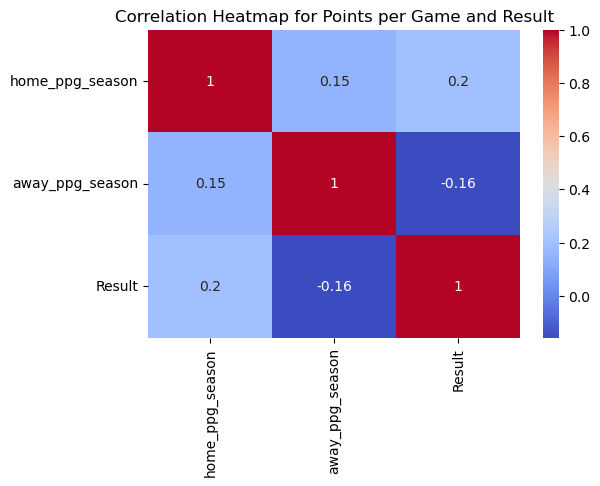

In [724]:
# plot a heatmap of home_ppg_season and away_ppg_season with result
plt.figure(figsize=(6, 4))
sns.heatmap(prem[['home_ppg_season', 'away_ppg_season', 'Result']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Points per Game and Result')
plt.show()


home points per game has 0.2 correlation and away_ppg_season has a negative correlation. Because these are somewhat zero sum in nature, the correlations may be cancelling each other out somewhat. But they are clearly somewhat correlated with the result so they ought to stay

## HTML of the match stats columns

In [725]:
prem['goal'].iloc[0]

'<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>406</event_incident_typefk><elapsed>22</elapsed><player2>38807</player2><subtype>header</subtype><player1>37799</player1><sortorder>5</sortorder><team>10261</team><id>378998</id><n>295</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><elapsed>24</elapsed><player2>24154</player2><subtype>shot</subtype><player1>24148</player1><sortorder>4</sortorder><team>10260</team><id>379019</id><n>298</n><type>goal</type><goal_type>n</goal_type></value></goal>'

In [726]:
# check the record with id column 4766 in the goal column - a 0-0 draw
prem[prem['id'] == 4766]['goal']

3037    <goal />
Name: goal, dtype: object

In [727]:
# check where it's a 1-0 win just one entry - the last entry in the data
prem['goal'].iloc[-1]

'<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>649</event_incident_typefk><coordinates><value>21</value><value>2</value></coordinates><elapsed>54</elapsed><subtype>tap_in</subtype><player1>239807</player1><sortorder>4</sortorder><team>8659</team><id>4910256</id><n>559</n><type>goal</type><goal_type>n</goal_type></value></goal>'

It's very hard to read without seeing the nesting. We can use BeautifulSoup to parse this and see what is actually in here, is it anything more detailed than what we see in the goals scored column already?

In [728]:
from bs4 import BeautifulSoup

# prettify the HTML content from a dataframe
def prettify_column(col):
    soup = BeautifulSoup(col, 'html.parser')
    return soup.prettify()

# Applying the function to the goal column
prem['goal_parsed'] = prem['goal'].apply(prettify_column)

# Now, you can print an example entry to see the formatted HTML
print(prem['goal_parsed'].iloc[0])


<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   406
  </event_incident_typefk>
  <elapsed>
   22
  </elapsed>
  <player2>
   38807
  </player2>
  <subtype>
   header
  </subtype>
  <player1>
   37799
  </player1>
  <sortorder>
   5
  </sortorder>
  <team>
   10261
  </team>
  <id>
   378998
  </id>
  <n>
   295
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   393
  </event_incident_typefk>
  <elapsed>
   24
  </elapsed>
  <player2>
   24154
  </player2>
  <subtype>
   shot
  </subtype>
  <player1>
   24148
  </player1>
  <sortorder>
   4
  </sortorder>
  <team>
   10260
  </team>
  <id>
   379019
  </id>
  <n>
   298
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
</goal>



In [729]:
print(prem['goal_parsed'].iloc[-1])

<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   649
  </event_incident_typefk>
  <coordinates>
   <value>
    21
   </value>
   <value>
    2
   </value>
  </coordinates>
  <elapsed>
   54
  </elapsed>
  <subtype>
   tap_in
  </subtype>
  <player1>
   239807
  </player1>
  <sortorder>
   4
  </sortorder>
  <team>
   8659
  </team>
  <id>
   4910256
  </id>
  <n>
   559
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
</goal>



### goal column contains:
- a < goal /> tag if there are no goals

- a value tag for every goal
    - within this value tag, there is a comment tag which has mostly 'n' but also other letters. I don't know the meaning of it yet
    - elapsed, which may be the minute of the game it was scored,
    - **goal subtype** including header, tap-in, good data here!
    - **coordinates** which must be X and Y, e.g. the tap-in has coordinates value 21, 2 (2 yards out from the goal?)
    - team id
    - id which I assume is a goal_id?

I want to extract:
- goal subtype and see what types they have recorded
- comment, to see if it can be entirely ignored if it's just 'n'
- later on, we will get elapsed, assuming this is time the goal was scored

In [730]:
# Function to extract <comment> and <subtype> values, with a check for <value> tags
def extract_comment_and_subtype(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Check if there is a <goal> tag and if it contains <value> tags
    goal_tag = soup.find('goal')
    if not goal_tag or not goal_tag.find_all('value'):
        return [], []  # Return empty lists if <goal> or <value> is not found
    
    # Extract all <comment> and <subtype> values within each <value> tag
    comments = [value_tag.find('comment').get_text() for value_tag in goal_tag.find_all('value') if value_tag.find('comment')]
    subtypes = [value_tag.find('subtype').get_text() for value_tag in goal_tag.find_all('value') if value_tag.find('subtype')]
    
    return comments, subtypes

# Apply the function to extract <comment> and <subtype> values from the 'goal' column
prem['goal_comments'], prem['goal_subtypes'] = zip(*prem['goal'].apply(extract_comment_and_subtype))

# Flatten the lists and get unique values
unique_comments = set([comment for sublist in prem['goal_comments'] for comment in sublist])
unique_subtypes = set([subtype for sublist in prem['goal_subtypes'] for subtype in sublist])

# Print the unique comments and subtypes
print("Unique Comments:", unique_comments)
print("Unique Subtypes:", unique_subtypes)


Unique Comments: {'psm', 'n', 'rp', 'npm', 'dg', 'o', 'p'}
Unique Subtypes: {'volley', 'deflected', 'loose_ball', 'missed', 'post', 'saved_back_into_play', 'bicycle_kick', 'saved', 'crossbar', 'tap_in', 'backheel', 'lob', 'indirect freekick', 'direct_freekick', 'distance', 'shot', 'header'}


We can see a lot of different subtypes including 'saved' or 'missed' which doesn't make sense. Let's see which fields have those

In [731]:
# check goal_subtypes for entries containing 'missed' and 'saved'
missed = prem[prem['goal_subtypes'].apply(lambda x: 'missed' in x or 'saved' in x)]

missed

,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin,...,home_team_ppg,away_team_ppg,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff,goal_parsed,goal_comments,goal_subtypes
41,1770,08/09,2008-11-15,13,Arsenal,0,2,Aston Villa,-1,-2,...,1.92,1.14,1.916667,10,1.666667,7,3,<goal>\n <value>\n <comment>\n npm\n </com...,"[npm, o, n]","[saved, shot]"
158,1887,08/09,2009-01-28,23,Blackburn Rovers,2,2,Bolton Wanderers,0,0,...,1.09,1.07,1.090909,11,1.045455,3,8,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, npm, n]","[shot, shot, shot, saved, shot]"
223,1952,08/09,2008-08-30,3,West Ham United,4,1,Blackburn Rovers,1,3,...,1.18,1.09,1.500000,3,2.000000,4,-1,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, o, n, dg, npm, n, n]","[header, shot, shot, saved, shot, shot]"
225,1954,08/09,2008-08-30,3,Everton,0,3,Portsmouth,-1,-3,...,1.52,0.91,1.500000,3,0.000000,0,3,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, npm, n]","[shot, shot, saved, distance]"
232,1961,08/09,2009-03-21,30,Newcastle United,1,3,Arsenal,-1,-2,...,1.17,1.92,1.000000,5,1.793103,9,-4,<goal>\n <value>\n <comment>\n npm\n </com...,"[npm, n, n, n, n]","[saved, header, loose_ball, shot, shot]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2752,4481,15/16,2015-12-26,18,Chelsea,2,2,Watford,0,0,...,1.97,1.18,1.058824,7,1.647059,12,-5,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, p, o, n, npm]","[volley, shot, missed]"
2754,4483,15/16,2015-12-26,18,Manchester City,4,1,Sunderland,1,3,...,1.93,1.07,1.882353,6,0.705882,6,0,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, n, n, npm]","[header, distance, header, shot, shot, missed]"
2888,4617,15/16,2015-08-23,3,West Bromwich Albion,2,3,Chelsea,-1,-1,...,1.12,1.97,0.500000,1,0.500000,1,0,<goal>\n <value>\n <comment>\n npm\n </com...,"[npm, n, n, n, n, n]","[saved, shot, tap_in, volley, shot, header]"
2939,4668,15/16,2016-04-16,34,West Bromwich Albion,0,1,Watford,-1,-1,...,1.12,1.18,1.212121,4,1.151515,1,3,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, npm, npm]","[volley, saved_back_into_play, saved]"


I was manually trying to compare the sum of Home GS + Away GS with the number of goal subtypes and there are some inconsistencies where saved and missed are involved. We can:

- spot check some records with those and see if goal has a value of 1 or 0
- run a pandas query for these where the sum of goals should add up to the length of the goal_subtypes list

In [732]:
print(missed['goal_parsed'].iloc[-1])

<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   393
  </event_incident_typefk>
  <coordinates>
   <value>
    23
   </value>
   <value>
    6
   </value>
  </coordinates>
  <elapsed>
   5
  </elapsed>
  <player2>
   103419
  </player2>
  <subtype>
   shot
  </subtype>
  <player1>
   286119
  </player1>
  <sortorder>
   6
  </sortorder>
  <team>
   8197
  </team>
  <id>
   5581005
  </id>
  <n>
   301
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   80
  </event_incident_typefk>
  <coordinates>
   <value>
    25
   </value>
   <value>
    7
   </value>
  </coordinates>
  <elapsed>
   33
  </elapsed>
  <subtype>
   shot
  </subtype>
  <player1>
   103419
  </player1>
  <sortorder>
   2
  </sortorder>
  <tea

## Key information from SQL to aid the analysis

SQL is going to be a lot easier to bring in information like how many goals on average did a given team score this season, team OVR rating for the season, player OVR ratings etc...

Before going for types of goals, possession etc etc I should be looking at high level team information, which is definitely going to impact the predictive power of the model.

The SQL query to be built is:
- Overall Rating From Player_Attributes, join their name
    - we need code to match the player's OVR ability to the year the match takes place e.g. 2015 match takes the player's 2015 OVR
- Joined by their player_api_id to Match table, which has player ID

In [733]:
# import the database file
with sqlite3.connect('/Users/thomasdoherty/Desktop/football-project/football-data/database.sqlite') as conn:
    # countries = pd.read_sql_query("SELECT England FROM Country", conn) # we don't need it for now, other than country id 1729

    matches = pd.read_sql_query("SELECT * FROM Match WHERE country_id IS 1729", conn)

    # leagues = pd.read_sql_query("SELECT * FROM League", conn) - we don't need this right now

    team = pd.read_sql_query("SELECT * FROM Team", conn)

    team_attr = pd.read_sql_query("""
                                  SELECT Team.team_api_id, team_long_name, date, buildUpPlaySpeed, buildUpPlayPassing, chanceCreationPassing, chanceCreationCrossing, chanceCreationShooting, defencePressure, defenceAggression
                                  FROM Team_Attributes
                                  INNER JOIN Team ON Team.team_api_id = Team_Attributes.team_api_id
                                  """, conn)

    player_attr = pd.read_sql_query("""
                                    SELECT Player.player_api_id, player_name, date, overall_rating 
                                    FROM Player_Attributes 
                                    INNER JOIN Player ON Player.player_api_id = Player_Attributes.player_api_id
                                    """, conn)

    player = pd.read_sql_query("SELECT * FROM Player", conn)

## Preparing the player_attribute table

- Better teams win more matches
- a more static measure of ability as these ratings only move slightly unless it is very young player. May be more a reflection of longer term prior performance
- We can take the average rating of the team's starting 11

The goal is to have the player id, their overall rating and the year in which it was assigned. This information will let the player easily be joined in to the matches table with their overall rating which is close to the time of the match in question.
    - We can then later create an average OVR rating of the team in the starting 11.

There are many instances of the same player having a new rating multiple times a year, so we will take an average of the overall rating that was given in each rating across each year.

In [734]:
player_attr[player_attr['player_api_id'] == 23021].head() # before preparation

,player_api_id,player_name,date,overall_rating
21897,23021,Boaz Myhill,2016-02-11 00:00:00,72.0
21898,23021,Boaz Myhill,2015-09-21 00:00:00,72.0
21899,23021,Boaz Myhill,2014-05-16 00:00:00,72.0
21900,23021,Boaz Myhill,2014-03-14 00:00:00,72.0
21901,23021,Boaz Myhill,2013-09-20 00:00:00,72.0


In [735]:
# cast date to datetime
player_attr['date'] = pd.to_datetime(player_attr['date'])

# extract just the year from the date
player_attr['date'] = player_attr['date'].dt.year

In [736]:
# now average the overall_rating for each player for each year, group by player_api_id and date
player_attr = player_attr.groupby(['player_api_id', 'player_name', 'date'])['overall_rating'].mean().reset_index()

# round the overall_rating to 1 decimal place
player_attr['overall_rating'] = player_attr['overall_rating'].round(1)

In [737]:
player_attr.dtypes

player_api_id       int64
player_name        object
date                int32
overall_rating    float64
dtype: object

In [738]:
player_attr.sample(5) # after preparation

,player_api_id,player_name,date,overall_rating
60931,214617,Michael Hector,2011,55.0
11701,27610,Stefano Morrone,2011,73.5
8724,26223,Bostjan Cesar,2014,72.9
71138,513810,Ahmed El Messaoudi,2016,64.2
68133,365666,Adam Campbell,2013,58.9


### Preparing the team_attribute columns

The goal is to have the team statistics for that year that the match took place. We may only bring in the team name but extra columns related to the style of play will be brought in too. 

I dropped buildUpPlayDribbling / chanceCreationDribbling because it only began getting recorded in 2014 - near the end of the data

Other notes:
- It looks like all teams get one annual rating for team_attr, so all we need to process is extract the year

- Spot check West Ham (long ball) vs Arsenal (short possession based) - it appears the **larger values for passing indicate longer passing distance**, e.g. long-ball teams have a larger buildUpPlaySpeed and buildUpPlayPassing

In [739]:
#teams[teams['team_api_id'] == 8654]

In [740]:
team_attr.sample(5) # before processing

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
1162,10179,FC Sion,2010-02-22 00:00:00,35,60,50,60,60,35,40
453,10235,Feyenoord,2012-02-22 00:00:00,38,34,60,44,50,43,43
326,7869,Córdoba CF,2012-02-22 00:00:00,40,53,40,71,48,36,41
405,8668,Everton,2011-02-22 00:00:00,60,50,55,70,55,55,65
725,8581,Levante UD,2010-02-22 00:00:00,30,30,45,40,70,30,35


In [741]:
team_attr.columns

Index(['team_api_id', 'team_long_name', 'date', 'buildUpPlaySpeed',
       'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing',
       'chanceCreationShooting', 'defencePressure', 'defenceAggression'],
      dtype='object')

In [742]:
# spot check a team to see how this changes - West Ham United and Arsenal
team_attr[team_attr['team_long_name'].isin(['West Ham United', 'Arsenal'])]

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
70,9825,Arsenal,2010-02-22 00:00:00,66,30,30,45,35,30,40
71,9825,Arsenal,2011-02-22 00:00:00,75,40,40,45,65,50,40
72,9825,Arsenal,2012-02-22 00:00:00,25,32,41,34,30,57,57
73,9825,Arsenal,2013-09-20 00:00:00,30,29,41,55,39,64,54
74,9825,Arsenal,2014-09-19 00:00:00,59,26,28,55,64,51,44
75,9825,Arsenal,2015-09-10 00:00:00,59,30,28,44,46,51,44
1384,8654,West Ham United,2010-02-22 00:00:00,58,30,31,70,50,30,70
1385,8654,West Ham United,2011-02-22 00:00:00,35,35,30,45,45,45,45
1386,8654,West Ham United,2012-02-22 00:00:00,63,64,44,60,55,30,34
1387,8654,West Ham United,2013-09-20 00:00:00,72,73,61,74,32,30,37


In [743]:
# cast date to datetime
team_attr['date'] = pd.to_datetime(team_attr['date'])

# extract just the year from the date
team_attr['date'] = team_attr['date'].dt.year

In [744]:
team_attr.sample(5)

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
1285,9941,Toulouse FC,2014,49,53,52,34,57,36,52
290,9925,Celtic,2012,70,58,54,58,60,50,50
721,8588,RC Lens,2012,64,49,49,53,34,46,44
642,8597,Kilmarnock,2011,36,36,37,52,51,48,43
44,9865,UD Almería,2015,46,65,57,54,40,37,53


### Big SQL Query - team match results in England

I want to create a df which has aggregated the win/loss/draw and avg goals scored for all teams in England (where the matches recorded are all from the Premier League).

We will use CASE logic to match the team id only when it is specifically home or away to count the goals scored and the goals per match
We can make it more granular later e.g. home wins/losses, away wins/losses if we want.

We can also adjust the below code to add other leagues for if we wanted to check which teams are most dominant in their leagues.

In [745]:
sql_query = """
SELECT
    Team.team_api_id,
    Team.team_long_name AS name,
    League.name AS league,
    COUNT(Match.id) AS total_matches,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal
                ELSE 0
        END) AS total_GS,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.away_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.home_team_goal
                ELSE 0
        END) AS total_GA,
    SUM(CASE 
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal > Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal > Match.home_team_goal THEN 1
                ELSE 0 
        END) AS total_wins,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal = Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal = Match.home_team_goal THEN 1
                ELSE 0
        END) AS total_draws,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal < Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal < Match.home_team_goal THEN 1
                ELSE 0
        END) AS total_losses,
    ROUND(AVG(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal
                ELSE 0
        END), 2) AS avg_GS_per_match,
    ROUND(AVG(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.away_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.home_team_goal
                ELSE 0
        END), 2) AS avg_GA_per_match

FROM Team

LEFT JOIN Match ON Team.team_api_id IN (Match.home_team_api_id, Match.away_team_api_id)

JOIN League ON League.id = Match.league_id

WHERE Team.team_api_id IS NOT NULL AND League.id = 1729

GROUP BY Team.team_long_name

ORDER BY total_wins DESC;
"""

In [746]:
# SQL query run

big_stats = pd.read_sql_query(sql_query, conn)

In [747]:
big_stats

,team_api_id,name,league,total_matches,total_GS,total_GA,total_wins,total_draws,total_losses,avg_GS_per_match,avg_GA_per_match
0,10260,Manchester United,England Premier League,304,582,280,192,57,55,1.91,0.92
1,8455,Chelsea,England Premier League,304,583,286,176,70,58,1.92,0.94
2,8456,Manchester City,England Premier League,304,606,307,175,61,68,1.99,1.01
3,9825,Arsenal,England Premier League,304,573,320,170,73,61,1.88,1.05
4,8586,Tottenham Hotspur,England Premier League,304,481,358,151,74,79,1.58,1.18
5,8650,Liverpool,England Premier League,304,531,337,150,76,78,1.75,1.11
6,8668,Everton,England Premier League,304,439,355,121,100,83,1.44,1.17
7,10194,Stoke City,England Premier League,304,322,401,98,86,120,1.06,1.32
8,10252,Aston Villa,England Premier League,304,335,462,86,88,130,1.10,1.52
9,10261,Newcastle United,England Premier League,266,324,422,82,65,119,1.22,1.59


In [748]:
big_stats.dtypes # types look good

team_api_id           int64
name                 object
league               object
total_matches         int64
total_GS              int64
total_GA              int64
total_wins            int64
total_draws           int64
total_losses          int64
avg_GS_per_match    float64
avg_GA_per_match    float64
dtype: object

In [749]:
# close the SQL connection
conn.close()

## Progress Check - SQL and Pandas

We have:

- `player_attr` player overall attribute for every year, which can be summed and averaged in the match data table, with player_api to connect to the team
- `team_attr` team statistics, with team_api_id and the date. If we have issues with nulls, we may want to start with just the 2010 - 2015 or 2016 years as some team attribute data is missing from 2008-2009
- `big_stats` aggregated team results for the 33 teams who have competed in the premier league in this 2008-2016 window
- `prem` which is a modified match table where all of this will be aggregated.

In [750]:
# spot check the team_attr for teams that could be pulled in
team_attr[team_attr['team_long_name'].isin(['Middlesbrough', 'Fulham'])]

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
478,9879,Fulham,2010,60,70,70,70,50,40,35
479,9879,Fulham,2011,50,55,45,55,40,45,35
480,9879,Fulham,2012,48,45,38,62,54,38,38
481,9879,Fulham,2013,52,49,49,56,59,39,39
482,9879,Fulham,2014,52,56,58,41,54,29,28
483,9879,Fulham,2015,52,48,39,54,59,29,30
829,8549,Middlesbrough,2010,70,70,70,70,50,30,70
830,8549,Middlesbrough,2011,66,51,64,64,48,54,44
831,8549,Middlesbrough,2012,60,72,40,56,72,38,42
832,8549,Middlesbrough,2013,60,40,40,56,57,38,42


### Sample Pulse Check for the four dfs

In [751]:
prem.sample(7)

,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin,...,home_team_ppg,away_team_ppg,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff,goal_parsed,goal_comments,goal_subtypes
1191,2920,11/12,2011-12-03,14,Blackburn Rovers,4,2,Swansea City,1,2,...,1.09,1.25,0.538462,2,1.076923,6,-4,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, n, n, p]","[shot, header, header, header, volley]"
2202,3931,13/14,2014-05-04,37,Chelsea,0,0,Norwich City,0,0,...,1.97,1.04,2.166667,9,0.888889,0,9,<goal>\n</goal>\n,[],[]
1899,3628,12/13,2012-10-27,9,Wigan Athletic,2,1,West Ham United,1,1,...,1.06,1.18,0.625000,1,1.750000,8,-7,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n]","[volley, shot, header]"
1873,3602,12/13,2012-10-07,7,Newcastle United,0,3,Manchester United,-1,-3,...,1.17,2.08,1.500000,6,2.000000,12,-6,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n]","[header, header, distance]"
1927,3656,13/14,2013-11-10,11,Sunderland,1,0,Manchester City,1,1,...,1.07,1.93,0.400000,3,1.900000,9,-6,<goal>\n <value>\n <comment>\n n\n </comme...,[n],[shot]
2071,3800,13/14,2014-02-08,25,Aston Villa,0,2,West Ham United,-1,-2,...,1.14,1.18,1.125000,7,0.916667,7,0,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n]","[shot, shot]"
2970,4699,15/16,2016-05-15,38,Arsenal,4,0,Aston Villa,1,4,...,1.92,1.14,1.837838,7,0.459459,1,6,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, o]","[header, shot, shot]"


In [752]:
player_attr.sample(7)

,player_api_id,player_name,date,overall_rating
37029,69713,Ondrej Mazuch,2011,72.0
45825,120737,Chengdong Zhang,2016,70.0
6174,24612,Fernando,2011,69.0
14053,30789,Petit,2011,75.0
26856,39440,Vangelis Moras,2010,69.0
38250,74739,Jorge Garcia,2010,67.0
48970,150573,Oscar Sielva,2009,64.0


In [753]:
team_attr.sample(7)

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
382,10268,Elche CF,2015,51,48,53,54,57,49,51
196,9857,Bologna,2015,63,48,32,48,52,30,54
203,9827,Girondins de Bordeaux,2010,70,35,70,50,70,55,70
1300,8600,Udinese,2012,75,45,65,65,50,45,55
1011,8640,PSV,2014,67,40,53,53,55,50,62
620,1957,Jagiellonia Białystok,2012,58,69,53,42,68,40,50
372,9810,Eintracht Frankfurt,2011,52,43,62,62,41,48,50


In [754]:
big_stats.sample(7)

,team_api_id,name,league,total_matches,total_GS,total_GA,total_wins,total_draws,total_losses,avg_GS_per_match,avg_GA_per_match
7,10194,Stoke City,England Premier League,304,322,401,98,86,120,1.06,1.32
23,8602,Wolverhampton Wanderers,England Premier League,114,118,204,25,28,61,1.04,1.79
4,8586,Tottenham Hotspur,England Premier League,304,481,358,151,74,79,1.58,1.18
21,8197,Leicester City,England Premier League,76,114,91,34,20,22,1.50,1.20
33,9798,Reading,England Premier League,38,43,73,6,10,22,1.13,1.92
29,8678,Bournemouth,England Premier League,38,45,67,11,9,18,1.18,1.76
12,8659,West Bromwich Albion,England Premier League,266,305,405,75,73,118,1.15,1.52


## Combining the dataframes

The goal is:
- In the Prem dataframe, we can replace the home_player_x and away_player_x which are currently just IDs with overall ability values using player_attr
- We can also add in an average OVR for both team's starting 11
    - later on, other team attributes we want to investigate
- We may want to add the team's avg GS and GA, but might this be a problem of collinearity with the classification result?
- We can then have a target column for classification of 1 (home win), 0 (draw) or -1 (away win)

In [755]:
prem.sample(5)

,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin,...,home_team_ppg,away_team_ppg,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff,goal_parsed,goal_comments,goal_subtypes
2722,4451,15/16,2015-12-07,15,Everton,1,1,Crystal Palace,0,0,...,1.52,1.18,1.500000,8,1.571429,7,1,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n]","[header, shot]"
2930,4659,15/16,2016-04-17,34,Arsenal,1,1,Crystal Palace,0,0,...,1.92,1.18,1.878788,11,1.121212,4,7,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n]","[header, distance]"
2967,4696,15/16,2016-05-07,37,Sunderland,3,2,Chelsea,1,1,...,1.07,1.97,0.972222,6,1.361111,7,-1,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, n, n]","[shot, volley, shot, shot, shot]"
128,1857,08/09,2008-12-28,20,West Bromwich Albion,2,0,Tottenham Hotspur,1,2,...,1.12,1.73,0.789474,4,1.052632,5,-1,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n]","[header, shot]"
463,2192,09/10,2009-12-15,17,Manchester United,3,0,Wolverhampton Wanderers,1,3,...,2.08,0.90,2.125000,9,1.000000,6,3,<goal>\n <value>\n <comment>\n p\n </comme...,"[p, n, n]","[header, volley]"


In [756]:
prem.columns

Index(['id', 'season', 'date', 'Gameweek / 38', 'home_team', 'Home GS',
       'Away GS', 'away_team', 'Result', 'Margin', 'Home ID', 'p(Home)',
       'p(Draw)', 'p(Away)', 'Away ID', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11',
       'goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner',
       'possession', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'goal_parsed', 'goal_comments', 'goal_subtypes'],
      dtype='object')

### Adding Player Ratings and Team statistics to prem df

In [757]:
# Convert the 'date' columns to datetime and extract the year
prem['date'] = pd.to_datetime(prem['date'])
prem['year'] = prem['date'].dt.year

player_attr['date'] = pd.to_datetime(player_attr['date'])
player_attr['year'] = player_attr['date'].dt.year

# Function to merge and find the nearest year if an exact match is not available
def merge_with_nearest_year(prem_df, player_attr_df, player_col, rating_col_prefix):
    # Sort player_attr by player_id and year
    player_attr_df = player_attr_df.sort_values(['player_api_id', 'year'])
    
    # Initialize a list to hold the rating data
    ratings = []

    # Iterate over each row in prem_df
    for _, row in prem_df.iterrows():
        player_id = row[player_col]
        match_year = row['year']

        # Filter player_attr for the current player_id
        player_data = player_attr_df[player_attr_df['player_api_id'] == player_id]

        # Find the closest year if there are any records for the player
        if not player_data.empty:
            closest_year = player_data.iloc[(player_data['year'] - match_year).abs().argsort()[:1]].squeeze()
            ratings.append(closest_year['overall_rating'])
        else:
            ratings.append(None)  # Append None if no data is available

    # Add the ratings to the prem_df
    prem_df[rating_col_prefix] = ratings

# Apply the function for home and away players
for n in range(1, 12):
    merge_with_nearest_year(prem, player_attr, f'home_player_{n}', f'home_player_{n}_rating')
    merge_with_nearest_year(prem, player_attr, f'away_player_{n}', f'away_player_{n}_rating')

# adding the team statistics to the prem df
prem = prem.merge(
    big_stats[['team_api_id', 'total_matches', 'avg_GS_per_match', 'avg_GA_per_match']],
    left_on='Home ID',
    right_on='team_api_id',
    how='left'
).rename(columns={
    'total_matches': 'home_total_matches',
    'avg_GS_per_match': 'home_avg_GS_per_match',
    'avg_GA_per_match': 'home_avg_GA_per_match'
}).drop(columns='team_api_id')

prem = prem.merge(
    big_stats[['team_api_id', 'total_matches', 'avg_GS_per_match', 'avg_GA_per_match']],
    left_on='Away ID',
    right_on='team_api_id',
    how='left'
).rename(columns={
    'total_matches': 'away_total_matches',
    'avg_GS_per_match': 'away_avg_GS_per_match',
    'avg_GA_per_match': 'away_avg_GA_per_match'
}).drop(columns='team_api_id')

In [758]:
prem.sample(10)

,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin,...,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_total_matches,home_avg_GS_per_match,home_avg_GA_per_match,away_total_matches,away_avg_GS_per_match,away_avg_GA_per_match
1675,3404,12/13,2013-01-19,23,Swansea City,3,1,Stoke City,1,2,...,72.0,76.5,74.0,77.0,190,1.23,1.35,304,1.06,1.32
832,2561,10/11,2010-12-05,16,Sunderland,1,0,West Ham United,1,1,...,83.5,73.0,77.0,74.0,304,1.10,1.45,266,1.23,1.44
831,2560,10/11,2010-12-06,16,Liverpool,3,0,Aston Villa,1,3,...,77.0,70.0,61.0,74.0,304,1.75,1.11,304,1.10,1.52
1090,2819,10/11,2010-09-19,5,Manchester United,3,2,Liverpool,1,1,...,91.5,86.5,84.5,87.0,304,1.91,0.92,304,1.75,1.11
1842,3571,12/13,2012-09-17,4,Everton,2,2,Newcastle United,0,0,...,76.0,67.0,67.0,77.0,304,1.44,1.17,266,1.22,1.59
384,2113,09/10,2009-08-15,1,Wolverhampton Wanderers,0,2,West Ham United,-1,-2,...,65.5,73.0,69.0,80.0,114,1.04,1.79,266,1.23,1.44
2839,4568,15/16,2016-02-06,25,Tottenham Hotspur,1,0,Watford,1,1,...,71.0,77.0,58.0,72.0,304,1.58,1.18,38,1.05,1.32
1263,2992,11/12,2012-01-02,20,Fulham,2,1,Arsenal,1,1,...,71.0,85.5,75.0,68.5,228,1.16,1.40,304,1.88,1.05
2317,4046,14/15,2014-11-22,12,Manchester City,2,1,Swansea City,1,1,...,75.0,64.0,80.0,56.0,304,1.99,1.01,190,1.23,1.35
558,2287,09/10,2010-02-06,25,Liverpool,1,0,Everton,1,1,...,81.5,76.0,61.0,82.5,304,1.75,1.11,304,1.44,1.17


It looks quite good - lots and lots of columns that need shaving somehow, but we got these in!

Let's check if any nulls are there.

In [759]:
# check every column for nulls by the columns with the most first
prem.isnull().sum().sort_values(ascending=False).head(20)

away_player_2            8
away_player_2_rating     8
away_player_10           8
away_player_10_rating    8
away_player_7_rating     7
away_player_5_rating     7
home_player_2_rating     7
home_player_10           7
home_player_8            7
away_player_5            7
home_player_2            7
home_player_8_rating     7
home_player_10_rating    7
away_player_7            7
away_player_9_rating     6
away_player_9            6
home_player_7_rating     5
home_player_7            5
away_player_11_rating    5
away_player_11           5
dtype: int64

We can see from the above that there are a handful of empty/null ratings because there's a null in the player_id column itself. e.g. away 10 and away 2 both have 8 nulls in the id and the rating.

There are onyl single digit number of nulls across over 3,000 games. For completeness, we can just fill the nulls ratings with the average of the respective team e.g. if away 10_rating is null, give him the average rating of the team around him.

In [760]:
# fill the home_player_x and away_player_x rating columns, if null, with the mean of the team's overall_rating
for n in range(1, 12):
    # Calculate the mean of the other players' ratings for the home team, each row
    home_rating_cols = [f'home_player_{i}_rating' for i in range(1, 12) if i != n] # if i != n is to exclude the current player in case the null is here
    prem[f'home_player_{n}_rating'] = prem.apply(
        lambda row: row[home_rating_cols].mean() if pd.isnull(row[f'home_player_{n}_rating']) else row[f'home_player_{n}_rating'],
        axis=1
    ) # for every row, run through the home player ratings and take the mean if the rating is null

    # same for away team
    away_rating_cols = [f'away_player_{i}_rating' for i in range(1, 12) if i != n]
    prem[f'away_player_{n}_rating'] = prem.apply(
        lambda row: row[away_rating_cols].mean() if pd.isnull(row[f'away_player_{n}_rating']) else row[f'away_player_{n}_rating'],
        axis=1
    )

In [761]:
# check for nulls again - only the IDs, not the ratings!
prem.isnull().sum().sort_values(ascending=False).head()

away_player_10    8
away_player_2     8
away_player_5     7
home_player_10    7
home_player_8     7
dtype: int64

In [762]:
prem.sample(10)

,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin,...,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_total_matches,home_avg_GS_per_match,home_avg_GA_per_match,away_total_matches,away_avg_GS_per_match,away_avg_GA_per_match
522,2251,09/10,2010-01-16,22,Tottenham Hotspur,0,0,Hull City,0,0,...,85.0,76.5,83.5,65.5,304,1.58,1.18,152,0.95,1.60
1493,3222,11/12,2011-10-01,7,Everton,0,2,Liverpool,-1,-2,...,77.0,66.5,82.5,62.0,304,1.44,1.17,304,1.75,1.11
1890,3619,12/13,2012-10-27,9,Arsenal,1,0,Queens Park Rangers,1,1,...,85.0,70.0,56.0,75.0,304,1.88,1.05,114,1.01,1.75
425,2154,09/10,2009-11-21,13,Hull City,3,3,West Ham United,0,0,...,65.5,77.0,63.5,73.0,152,0.95,1.60,266,1.23,1.44
1579,3308,12/13,2012-11-28,14,Everton,1,1,Arsenal,0,0,...,70.5,71.0,67.0,56.0,304,1.44,1.17,304,1.88,1.05
1336,3065,11/12,2012-03-03,27,Stoke City,1,0,Norwich City,1,1,...,46.0,48.0,77.0,61.5,304,1.06,1.32,152,1.05,1.66
1648,3377,12/13,2012-12-29,20,Stoke City,3,3,Southampton,0,0,...,46.0,64.0,62.0,49.0,304,1.06,1.32,152,1.42,1.18
1264,2993,11/12,2012-01-03,20,Manchester City,3,0,Liverpool,1,3,...,76.5,81.5,64.0,62.0,304,1.99,1.01,304,1.75,1.11
1303,3032,11/12,2012-02-04,24,Manchester City,3,0,Fulham,1,3,...,81.0,73.0,64.0,71.0,304,1.99,1.01,228,1.16,1.40
2661,4390,15/16,2015-08-08,1,Bournemouth,0,1,Aston Villa,-1,-1,...,65.0,60.0,54.0,74.0,38,1.18,1.76,304,1.10,1.52


## Joins and merges complete - Further cleaning & Feature Engineering of the prem dataframe

### Summary so far and plans ahead:

We have created a master `prem` dataframe which has all the matches from 08/09 to 15/16. Columns of value include
- Match data such as:
    - Team IDs, 
    - date of the fixture,
    - match week of 38. Probably not relevant for predicting the result, but maybe for details match stats later.

- Player data for the home and away players such as:
    - Individual player's overall ratings on both teams, that are recent to the match date

- Team data for the home and away team such as:
    - Team's total number of matches in the league in the reference period. 
    - Teams avg goals scored (GS) and goals against (GA) per game in the time window.
    - These might be a complicated one because that's gathering future information if we are predicting a game early on in the time window.
    
- Details match information like shots, types of goal scored, possession, bookings etc etc but these are heavily nested in columns which we need to dig out later.

Now we can clean a number of unneccessary columns and add one important one:
- Create an average 'team' rating for each match. I think this will be the best way to construct a simple model with some predictive power before complicating things with 22 individual player ratings.

- Remove the individual player IDs, match_api_id

- **For now** remove the Round / 38 aka gameweek, home and away_total matches


### Removing currently (MVP) unnecessary columns

In [763]:
prem.columns

Index(['id', 'season', 'date', 'Gameweek / 38', 'home_team', 'Home GS',
       'Away GS', 'away_team', 'Result', 'Margin', 'Home ID', 'p(Home)',
       'p(Draw)', 'p(Away)', 'Away ID', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11',
       'goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner',
       'possession', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'goal_parsed', 'goal_comments', 'goal_subtypes',
       'year', 'home_player_1_rating', 'away_player_1_rating',
       'home_player_2_rating', 'away_player_2_rat

In [764]:
# drop the Gameweek / 38 column, id, home_total_matches, away_total_matches, year
prem = prem.drop(['Gameweek / 38', 'id', 'home_total_matches', 'away_total_matches', 'year'], axis=1)

In [765]:
# drop the home/away_player_X columns but NOT the ratings
prem = prem.drop(prem.filter(regex='^(home|away)_player_[1-9]$|^(home|away)_player_10$|^(home|away)_player_11$').columns, axis=1)

In [766]:
# remove the match detail columns - goal, shoton, shotoff, foulcommit, card, cross, corner, possession, goal_parsed, goal_comments, goal_subtypes
prem = prem.drop(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession', 'goal_parsed', 'goal_comments', 'goal_subtypes'], axis=1)

In [767]:
prem.columns

Index(['season', 'date', 'home_team', 'Home GS', 'Away GS', 'away_team',
       'Result', 'Margin', 'Home ID', 'p(Home)', 'p(Draw)', 'p(Away)',
       'Away ID', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'home_player_1_rating', 'away_player_1_rating',
       'home_player_2_rating', 'away_player_2_rating', 'home_player_3_rating',
       'away_player_3_rating', 'home_player_4_rating', 'away_player_4_rating',
       'home_player_5_rating', 'away_player_5_rating', 'home_player_6_rating',
       'away_player_6_rating', 'home_player_7_rating', 'away_player_7_rating',
       'home_player_8_rating', 'away_player_8_rating', 'home_player_9_rating',
       'away_player_9_rating', 'home_player_10_rating',
       'away_player_10_rating', 'home_player_11_rating',
       'away_player_11_rating', 'home_avg_GS_per_match',
       'home_avg_GA_per_match', 'away_avg_GS_per_match',
       'away_avg_GA_per_m

### Creating a home and away team match-day overall rating

In [768]:
# Calculate the average overall rating for the home team players
home_rating_cols = [f'home_player_{n}_rating' for n in range(1, 12)]
prem['home_avg_rating'] = prem[home_rating_cols].mean(axis=1)

# Calculate the average overall rating for the away team players
away_rating_cols = [f'away_player_{n}_rating' for n in range(1, 12)]
prem['away_avg_rating'] = prem[away_rating_cols].mean(axis=1)

In [769]:
prem.columns

Index(['season', 'date', 'home_team', 'Home GS', 'Away GS', 'away_team',
       'Result', 'Margin', 'Home ID', 'p(Home)', 'p(Draw)', 'p(Away)',
       'Away ID', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'home_player_1_rating', 'away_player_1_rating',
       'home_player_2_rating', 'away_player_2_rating', 'home_player_3_rating',
       'away_player_3_rating', 'home_player_4_rating', 'away_player_4_rating',
       'home_player_5_rating', 'away_player_5_rating', 'home_player_6_rating',
       'away_player_6_rating', 'home_player_7_rating', 'away_player_7_rating',
       'home_player_8_rating', 'away_player_8_rating', 'home_player_9_rating',
       'away_player_9_rating', 'home_player_10_rating',
       'away_player_10_rating', 'home_player_11_rating',
       'away_player_11_rating', 'home_avg_GS_per_match',
       'home_avg_GA_per_match', 'away_avg_GS_per_match',
       'away_avg_GA_per_m

the average team ability is important, and so is the best player in the team. Create 2 columns: best_home_player and best_away_player ratings

In [770]:
# add column for best home player rating and best away player rating
prem['best_home_player_rating'] = prem[home_rating_cols].max(axis=1)
prem['best_away_player_rating'] = prem[away_rating_cols].max(axis=1)

In [771]:
prem.sample(10)

,season,date,home_team,Home GS,Away GS,away_team,Result,Margin,Home ID,p(Home),...,home_player_11_rating,away_player_11_rating,home_avg_GS_per_match,home_avg_GA_per_match,away_avg_GS_per_match,away_avg_GA_per_match,home_avg_rating,away_avg_rating,best_home_player_rating,best_away_player_rating
2754,15/16,2015-12-26,Manchester City,4,1,Sunderland,1,3,8456,0.457,...,56.0,59.0,1.99,1.01,1.10,1.45,68.681818,64.409091,81.0,78.0
692,09/10,2010-05-09,Chelsea,8,0,Wigan Athletic,1,8,8455,0.457,...,82.0,73.0,1.92,0.94,1.05,1.68,83.727273,69.272727,90.5,75.5
1031,10/11,2011-04-23,Liverpool,5,0,Birmingham City,1,5,8650,0.457,...,66.5,74.0,1.75,1.11,0.99,1.38,71.818182,70.454545,86.5,81.0
1228,11/12,2011-12-21,Manchester City,3,0,Stoke City,1,3,8456,0.457,...,80.0,62.0,1.99,1.01,1.06,1.32,76.863636,68.000000,83.5,81.5
1982,13/14,2013-12-21,Fulham,2,4,Manchester City,-1,-2,9879,0.457,...,70.0,67.0,1.16,1.40,1.99,1.01,75.363636,75.045455,82.0,83.5
794,10/11,2010-11-10,Wigan Athletic,1,1,Liverpool,0,0,8528,0.457,...,73.0,87.0,1.05,1.68,1.75,1.11,66.909091,77.727273,75.0,88.5
151,08/09,2009-01-27,Tottenham Hotspur,3,1,Stoke City,1,2,8586,0.457,...,83.5,77.0,1.58,1.18,1.06,1.32,76.363636,68.590909,83.5,77.0
4,08/09,2008-08-17,Aston Villa,4,2,Manchester City,1,2,10252,0.457,...,78.0,58.0,1.10,1.52,1.99,1.01,76.636364,70.050000,83.0,80.5
1975,13/14,2013-12-14,Manchester City,6,3,Arsenal,1,3,8456,0.457,...,67.0,56.0,1.99,1.01,1.88,1.05,77.454545,69.090909,83.5,86.0
1172,11/12,2011-11-19,Manchester City,3,1,Newcastle United,1,2,8456,0.457,...,78.0,65.0,1.99,1.01,1.22,1.59,77.227273,69.727273,83.5,78.0


### drop the individual player ratings to simplify the df for now

In [772]:
# drop the home/away_player_X_rating columns
prem = prem.drop(prem.filter(regex='^(home|away)_player_[1-9]_rating$|^(home|away)_player_10_rating$|^(home|away)_player_11_rating$').columns, axis=1)

Home / Away net goals - this should standardize around 0 for teams that score and concede equally, and negative for 'weak' teams while positive for 'good' teams

In [773]:
# create a new net goals column for both teams: home_avg_GS_per_match - home_avg_GA_per_match and away_avg_GS_per_match - away_avg_GA_per_match
prem['home_net_goals'] = prem['home_avg_GS_per_match'] - prem['home_avg_GA_per_match']
prem['away_net_goals'] = prem['away_avg_GS_per_match'] - prem['away_avg_GA_per_match']

In [774]:
# drop the home_avg_GS_per_match, home_avg_GA_per_match, away_avg_GS_per_match, away_avg_GA_per_match
prem = prem.drop(['home_avg_GS_per_match', 'home_avg_GA_per_match', 'away_avg_GS_per_match', 'away_avg_GA_per_match'], axis=1)

In [775]:
prem.columns

Index(['season', 'date', 'home_team', 'Home GS', 'Away GS', 'away_team',
       'Result', 'Margin', 'Home ID', 'p(Home)', 'p(Draw)', 'p(Away)',
       'Away ID', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'home_avg_rating', 'away_avg_rating',
       'best_home_player_rating', 'best_away_player_rating', 'home_net_goals',
       'away_net_goals'],
      dtype='object')

In [778]:
prem.sample(5)

,season,date,home_team,Home GS,Away GS,away_team,Result,Margin,Home ID,p(Home),...,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff,home_avg_rating,away_avg_rating,best_home_player_rating,best_away_player_rating,home_net_goals,away_net_goals
286,08/09,2009-05-02,Portsmouth,0,3,Arsenal,-1,-3,8462,0.457,...,9,1.911765,13,-4,75.772727,73.045455,80.0,83.0,-0.67,0.83
2480,14/15,2015-03-03,Aston Villa,2,1,West Bromwich Albion,1,1,10252,0.457,...,0,1.111111,8,-8,60.227273,67.454545,75.0,77.5,-0.42,-0.37
1618,12/13,2012-12-22,West Ham United,1,2,Everton,-1,-1,8654,0.457,...,4,1.588235,7,-3,71.136364,74.136364,80.0,80.0,-0.21,0.27
824,10/11,2010-11-27,Everton,1,4,West Bromwich Albion,-1,-3,8668,0.457,...,6,1.142857,1,5,76.727273,69.227273,81.5,79.5,0.27,-0.37
1513,11/12,2011-10-22,Bolton Wanderers,0,2,Sunderland,-1,-2,8559,0.457,...,3,0.750000,4,-1,70.954545,69.227273,80.5,79.5,-0.47,-0.35


In [780]:
# reorganize the dataframe: season, date, home team stats, away team stats, result, leave out the Home/Away ID columns and date, leave out margin
prem = prem[['season', 'date', 'home_team', 'home_team_ppg', 'home_ppg_season', 'home_pts_last_5', 'home_avg_rating', 'best_home_player_rating', 'home_net_goals', 'away_team', 'away_team_ppg', 'away_ppg_season', 'away_pts_last_5', 'away_avg_rating', 'best_away_player_rating','away_net_goals', 'Result', 'p(Home)', 'p(Draw)', 'p(Away)']]

In [781]:
# round the avg_rating columns to 1 decimal places
prem['home_avg_rating'] = prem['home_avg_rating'].round(1)
prem['away_avg_rating'] = prem['away_avg_rating'].round(1)

### convert seasons to a number beginning 08-09 with Season 1, 09-10 Season 2 etc, to see if results change over time (complete later)

In [ ]:
def season_to_number(season): # convert the season to a number
    try:
        # Strip any whitespace and split by '/'
        season = season.strip()
        # Extract the first year (e.g., '08' from '08/09')
        year = int(season.split('/')[0])
        # Subtract 7 to start numbering from 1 for '08/09'
        return year - 7
    except (ValueError, AttributeError):
        print(f"Invalid season value: {season}")
        return None  # Handle invalid cases gracefully

In [ ]:
print(prem['season'].unique())

['08/09' '09/10' '10/11' '11/12' '12/13' '13/14' '14/15' '15/16']


In [ ]:
prem['season'].isnull().sum()

0

### final drop of some columns

In [ ]:
# drop season column - for now
prem = prem.drop('season', axis=1)

# drop date column - for now
prem = prem.drop('date', axis=1)

# drop margin column - for now - already did in v2 of model build
# prem = prem.drop('Margin', axis=1)

In [786]:
prem.sample(5)

,home_team,home_team_ppg,home_ppg_season,home_pts_last_5,home_avg_rating,best_home_player_rating,home_net_goals,away_team,away_team_ppg,away_ppg_season,away_pts_last_5,away_avg_rating,best_away_player_rating,away_net_goals,Result,p(Home),p(Draw),p(Away)
722,West Ham United,1.18,1.400000,7,71.2,82.0,-0.21,Liverpool,1.73,1.800000,9,79.7,88.5,0.64,-1,0.457,0.258,0.285
2011,Cardiff City,0.79,0.000000,0,64.6,80.0,-1.11,Manchester City,1.93,3.000000,3,75.6,83.5,0.98,1,0.457,0.258,0.285
2345,Queens Park Rangers,0.81,0.785714,4,70.4,81.0,-0.74,Burnley,0.83,0.857143,8,58.4,69.5,-0.86,1,0.457,0.258,0.285
154,Portsmouth,0.91,1.227273,4,77.0,80.0,-0.67,Aston Villa,1.14,2.000000,13,74.6,83.0,-0.42,-1,0.457,0.258,0.285
2488,Stoke City,1.25,1.444444,10,60.0,77.0,-0.26,Everton,1.52,1.037037,5,69.3,81.5,0.27,1,0.457,0.258,0.285


In [787]:
# final clearing of some long decimal places - round home_team_ppg, home_ppg_season, away_team_ppg, away_ppg_season to 2 decimal places
prem['home_team_ppg'] = prem['home_team_ppg'].round(2)
prem['home_ppg_season'] = prem['home_ppg_season'].round(2)
prem['away_team_ppg'] = prem['away_team_ppg'].round(2)
prem['away_ppg_season'] = prem['away_ppg_season'].round(2)


## Correlation tests

In [788]:
prem.sample(5)

,home_team,home_team_ppg,home_ppg_season,home_pts_last_5,home_avg_rating,best_home_player_rating,home_net_goals,away_team,away_team_ppg,away_ppg_season,away_pts_last_5,away_avg_rating,best_away_player_rating,away_net_goals,Result,p(Home),p(Draw),p(Away)
841,Tottenham Hotspur,1.73,1.62,11,73.2,83.5,0.40,Chelsea,1.97,1.88,5,80.2,90.5,0.98,0,0.457,0.258,0.285
379,Chelsea,1.97,2.50,13,83.5,90.5,0.98,Liverpool,1.73,2.50,13,81.5,88.5,0.64,-1,0.457,0.258,0.285
978,Bolton Wanderers,1.07,1.32,7,72.0,82.5,-0.47,Aston Villa,1.14,1.18,8,69.0,83.5,-0.42,1,0.457,0.258,0.285
470,Arsenal,1.92,2.06,7,76.4,85.0,0.83,Hull City,0.90,1.00,6,68.0,79.5,-0.65,1,0.457,0.258,0.285
266,Portsmouth,0.91,1.06,6,76.4,80.0,-0.67,Bolton Wanderers,1.07,1.16,4,73.6,82.5,-0.47,1,0.457,0.258,0.285


Preparing the data by scaling it below

#### Notes for V2 run 
for v2 I will take ppg_season, not the other ppg (home_team_ppg or away_team_ppg, these are the multi year averages)

Below, I can see the **best player rating correlates better with Result than the average team rating, so home/away_avg_rating will be removed from this v2 run**

In [797]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Example: Select relevant columns for collinearity analysis
features = ['home_net_goals', 'away_net_goals', 'home_ppg_season', 'away_ppg_season','home_pts_last_5', 'away_pts_last_5', 'best_home_player_rating', 'best_away_player_rating', 'p(Home)', 'p(Draw)', 'p(Away)']
X = prem[features]  # Exclude the 'Result' column (that's the target variable)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

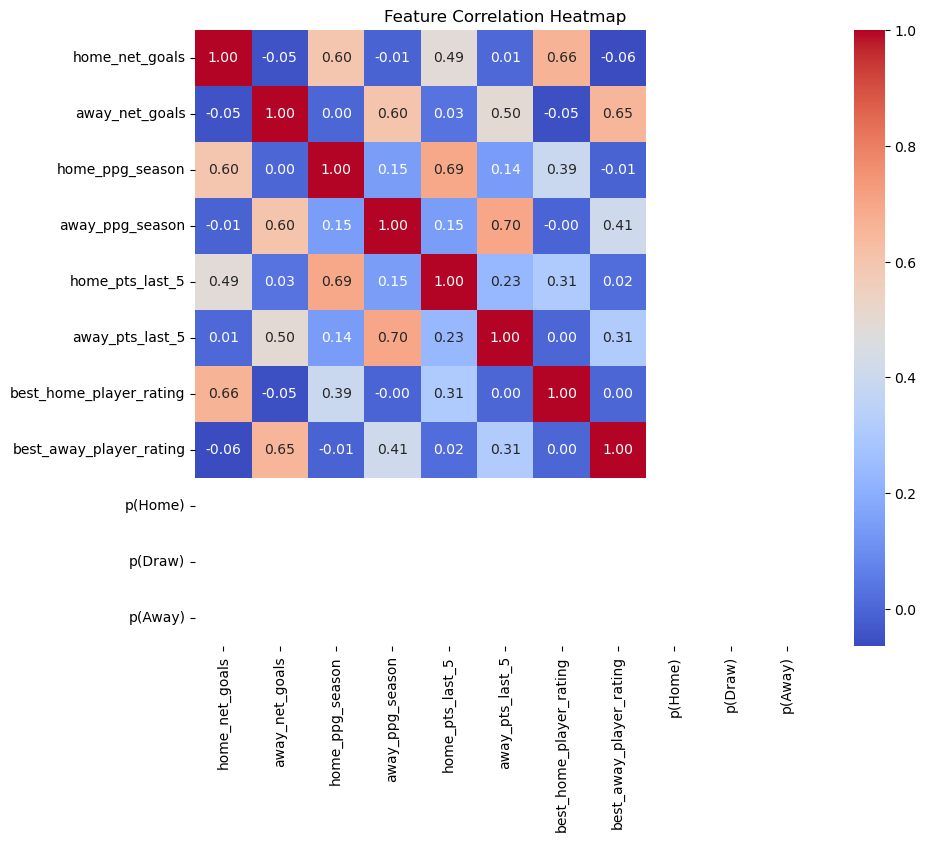

In [ ]:
# Calculate correlation matrix
correlation_matrix = pd.DataFrame(X_scaled, columns=features).corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Notes:
- I can see that the best player rating correlates more with the net_goals than the average team rating for home and away.
- home_pts_last_5 correlates very strongly with ppg_season suggesting that very recent form tends not to deviate much from season long form (dramatic turnarounds/flops are rare)

### Why does home_avg_rating correlate with away_avg_rating? - Structural Symmetry in team data

There are some sensible correlations here like away average rating and away net goals being 0.45 correlated.

But notice that the home net goals and home avg rating is also 0.45 - is it a coincidence?

What about the fact that home_avg_rating and away_avg_rating are 0.35 correlated? On face value, this is saying that better teams means are more likely to play each other. This doesn't make sense in the Premier League format where every team must play every other team twice every season... **home and away.**

In this data, every team appears as the home team and the away team an equal number of times (every team plays 19 home games and 19 away games every season) so there is a natural symmetry in the away and home team data at the highest level.

So we should be mindful of symmetry in this dataset, this is a correlation but the rating of the away team and the home team are conceptually distinct.

## PCA examining importance of columns

In [799]:
# Perform PCA
pca = PCA(n_components=len(features))  # Use all components initially
pca.fit(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Loadings (feature contributions to components)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(features))], index=features)

# Display loadings
print(loadings)

Explained Variance Ratio: [0.3445326  0.30938553 0.11425678 0.08558323 0.04502204 0.03866548
 0.03353777 0.02901657 0.         0.         0.        ]
                              PC1       PC2       PC3       PC4       PC5  \
home_net_goals           0.315573 -0.435648  0.262789 -0.147521  0.339647   
away_net_goals           0.354664  0.397509  0.257963  0.152085  0.352185   
home_ppg_season          0.382614 -0.357833 -0.233039  0.308378  0.349709   
away_ppg_season          0.411945  0.325994 -0.188521 -0.326034  0.313875   
home_pts_last_5          0.382406 -0.299498 -0.372290  0.395041 -0.414908   
away_pts_last_5          0.398441  0.276505 -0.359567 -0.417193 -0.386142   
best_home_player_rating  0.261925 -0.367181  0.516341 -0.440818 -0.337454   
best_away_player_rating  0.291446  0.341914  0.489952  0.478837 -0.323516   
p(Home)                  0.000000  0.000000 -0.000000 -0.000000  0.000000   
p(Draw)                  0.000000  0.000000 -0.000000 -0.000000  0.000000   
p(A

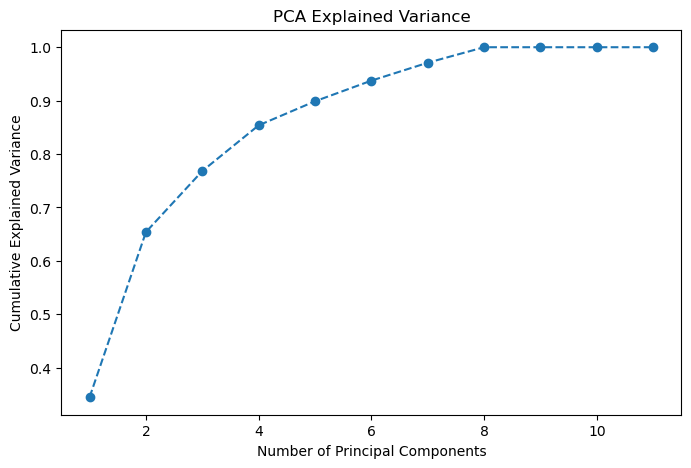

In [801]:
# visualizing the PCA results

# Cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(features) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

### Analysis of PCA Results / Loadings

#### (V2)

The key piece to PCA in V2 is even after engineering new features like points per game this season so far, points accrued in last 5 games... The principal component 2 still has home and away positive and negative respectively, which tells me that the differential between the to teams metrics is the important feature to carry forward.

We can take four PCs forward in  v2

#### (V1)

1. PC1 is very highly loaded onto the home and away team average ratings, almost identially so, as well to the home and away goals - again, almost identically so.
    - This is because of the structural symmetry identified before. PC1 captures 40% (0.395) of the variance in the feature set, which is heavily influenced by the team's rating, and it applies equally to the home and away team.

2. PC2 is symmetrical but is now distinguishing between the home and the away teams. PC2 captures 35% (0.352) of the data variance. Essentially, the home vs away team comparison.
    - We are being told that the rating and net goals of a team, *as it moves in the other direction of the opposition*, captures a lot of variance

3. PC3 is dominated by net goals, suggesting the performance specific variance that doesn't depend on the team's average rating

**With 3 principal components we have explained around 91% of the variance in the data set.** The prior probabilities p(home), p(away) and p(draw) are disregartded by PCA because they're constants that do not provide any variance to the dataset, but they are still important to the classification.

**IMPORTANT:** This is not explaining the variance in Results, it's variance in the dataset minus the results because PCA did not see the Result column. This is capturing overall variance in this data set. However, high variance features tend to be predictive and PCA has identified these, which we could use in our model or take learnings from the loadings of PC1, 2 and 3 and engineer our own.

The Principal Components here are representations of the original data columns and their variance. If we include them, we don't need to keep the home_avg_rating, home_net_goals and away equivalents. This *might* make the model perform better in classification tasks, but we will lose interpretability. There is also the risk that PCA is prioritizing variance in features that aren't predictive of the result, which is a lose-lose: less interpretability, and a weaker model.

Ideally we have both interpretability and good model performance and we can keep the interpretability by feature engineering information that PCA revealed was important, such as the differential between net goals of the home and away team, and the differential of the team's overall ratings. 

If the performance here is poor, we can fall back on PC1, 2 and 3 and make another model. PCA is still valuable for supervised learning because it has guided our feature engineering here, and has allowed us to go from four features (home/away_avg_rating/net_goals) to two features (**rating_diff and net_goals_diff**).

#### **The advantage of this feature engineering is that the zero-sum nature of matches allow a natural mean/equality of 0 and any positive values indicate favour for the home team, and any negative indivates away team favour.**



## Next Steps for building the model

1. Manual Run with feature engineering differential columns (and prior probabilities), using a logistic regression algorithm. We will create these features and save the csv for model building in another workbook.

2. PCA run with PC1-3 and prior probabilities using another algorithm (possibly random forest?). We'll add the PCA columns and save a separate csv for this separate model building in another workbook.

### 1. Manual Run - saved and model built on *logistic_reg_prem.ipynb*

In [803]:
# v2 with more features - make the differential columns for each feature
prem['ppg_diff'] = prem['home_team_ppg'] - prem['away_team_ppg']
prem['ppg_season_diff'] = prem['home_ppg_season'] - prem['away_ppg_season']
prem['pts_last_5_diff'] = prem['home_pts_last_5'] - prem['away_pts_last_5']
prem['avg_rating_diff'] = prem['home_avg_rating'] - prem['away_avg_rating']
prem['best_player_diff'] = prem['best_home_player_rating'] - prem['best_away_player_rating']
prem['net_goals_diff'] = prem['home_net_goals'] - prem['away_net_goals']

prem.sample(5)

,home_team,home_team_ppg,home_ppg_season,home_pts_last_5,home_avg_rating,best_home_player_rating,home_net_goals,away_team,away_team_ppg,away_ppg_season,...,Result,p(Home),p(Draw),p(Away),ppg_diff,ppg_season_diff,pts_last_5_diff,avg_rating_diff,best_player_diff,net_goals_diff
2779,West Ham United,1.18,3.00,3,61.0,77.0,-0.21,Leicester City,1.61,3.00,...,-1,0.457,0.258,0.285,-0.43,0.00,0,-0.4,-2.5,-0.51
1210,Aston Villa,1.14,1.27,7,70.5,83.0,-0.42,Liverpool,1.73,1.73,...,-1,0.457,0.258,0.285,-0.59,-0.46,-1,-0.8,-1.0,-1.06
2844,Crystal Palace,1.18,1.28,1,59.8,79.0,-0.28,Watford,1.18,1.32,...,-1,0.457,0.258,0.285,0.00,-0.04,-3,-6.5,-2.0,-0.01
1410,Arsenal,1.92,1.94,12,74.7,85.5,0.83,Wigan Athletic,1.06,0.94,...,-1,0.457,0.258,0.285,0.86,1.00,2,6.8,10.5,1.46
2829,Everton,1.52,1.26,3,67.6,81.5,0.27,Newcastle United,1.17,0.91,...,1,0.457,0.258,0.285,0.35,0.35,-1,6.8,4.0,0.64


Rather than drop the old columns we'll create a manual_run_df and just not include them there. 
- I want to include the points per game this season rather than the whole dataframe to reflect recent form. Therefore ppg_season, not ppg is in here for V2
- For now we will remove avg_rating for the team and just keep best player - the best players will usually not be completely alone in the team and that stops young academy players weighing down the average of the team according to the FIFA statistics where the ratings come from

- In the early part of the season as form is still being established, the net_goals can be beneficial as a prior, and it was valuable in the last model so let's keep that.
- I want to keep pts last 5 for both teams because a single last_5_games difference column will not distinguish between teams who've picked up 15 points vs 8 points and a team who've picked up 8 pts vs 1. Two teams in Excellent and good form is a different matchup to teams in good and awful form. It may be useful to predict draws

In [804]:
# Create the "manual run" DataFrame
manual_run_prem = prem[['ppg_season_diff', 'net_goals_diff', 'home_pts_last_5','away_pts_last_5', 'pts_last_5_diff', 'best_player_diff', 'p(Home)', 'p(Draw)', 'p(Away)', 'Result']]

In [805]:
manual_run_prem.sample(7)

,ppg_season_diff,net_goals_diff,home_pts_last_5,away_pts_last_5,pts_last_5_diff,best_player_diff,p(Home),p(Draw),p(Away),Result
2102,-1.44,-1.22,2,11,-9,-7.0,0.457,0.258,0.285,-1
2245,1.00,0.52,8,3,5,2.0,0.457,0.258,0.285,1
377,0.74,-0.43,10,4,6,0.5,0.457,0.258,0.285,0
2020,1.26,1.94,8,4,4,12.0,0.457,0.258,0.285,1
57,0.23,0.11,7,1,6,-0.5,0.457,0.258,0.285,1
451,0.20,0.37,5,4,1,2.5,0.457,0.258,0.285,0
591,0.03,0.26,7,4,3,-0.5,0.457,0.258,0.285,-1


### 2. PCA Run - Saved and model built on *random_forest_prem.ipynb*

We will:
1. run PCA on the columns of importance
2. concatenate those PCs to the dataframe
3. export to csv and build another model (likely random forest) in another workbook

In [807]:
# PCA setup - not including the p(home), p(draw), p(away) columns as they don't have loading in the PCA
pca_cols = ['home_net_goals', 'away_net_goals', 'home_ppg_season', 'away_ppg_season','home_pts_last_5', 'away_pts_last_5', 'best_home_player_rating', 'best_away_player_rating']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(prem[pca_cols])

In [ ]:
# Perform PCA on just the four columns from original PCA analysis
pca = PCA(n_components=4)  # Reduce to 4 components - for V2 the four PCs that had ~85% variance
X_pca = pca.fit_transform(X_scaled)

In [809]:
# add PC1, PC2, PC3, PC4 to the dataframe
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=prem.index)

In [810]:
pca_run_prem = pd.concat([pca_df, prem[['p(Home)', 'p(Draw)', 'p(Away)', 'Result']]], axis=1)

## Save DataFrames as CSVs to build model in next notebooks

In [811]:
manual_run_prem.to_csv('manual_run_prem_v2.csv', index=False) # index=False to avoid writing the index column

In [812]:
pca_run_prem.to_csv('pca_run_prem_v2.csv', index=False)

Pearson correlation test?

use clustering to break out the type of matches being played e.g. a tense 0-0 or a goalfest based on the stats